In [169]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from imblearn.pipeline import Pipeline
import pandas as pd
import time
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import learning_curve
import random
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from imblearn.pipeline import Pipeline
import shap
from sklearn.inspection import permutation_importance
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from xgboost import plot_importance
import pickle
import seaborn as sns
sns.set_theme(style="white", palette="rocket_r")

In [164]:
# 6-hour death prediction
X_train = np.load('X_train_static_6.npy')
X_test = np.load('X_test_static_6.npy')
y_train = np.load('y_train_static_6.npy')
y_test = np.load('y_test_static_6.npy')

In [165]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(X_train)
X_train_res = imp_mean.transform(X_train)
X_test_res = imp_mean.transform(X_test)

In [166]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [168]:
# Define the imputation and tuning pipeline
TabNet = TabNetClassifier()
imputer = IterativeImputer()
pipeline = Pipeline(steps=[('i', imputer), ('m', TabNet)])

Device used : cpu


In [ ]:
# Function that instantiates a tabnet model.
def create_tabnet(n_d=32, n_steps=5, optimizer_params=0.02, gamma=1.5, 
                  n_independent=2, n_shared=2, lambda_sparse=1e-4, 
                  momentum=0.3, clip_value=2.):
    
    model = TabNetClassifier(
        n_d=n_d, n_a=n_d, n_steps=n_steps,
        optimizer_params=optimizer_params,
        gamma=gamma, n_independent=n_independent, n_shared=n_shared,
        lambda_sparse=lambda_sparse, momentum=momentum, clip_value=clip_value,
        optimizer_fn=torch.optim.Adam,
        scheduler_params = {"gamma": 0.95,
                         "step_size": 20},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15, verbose = 0
    )
    return model

In [91]:
# Generate the parameter grid.
param_grid = dict(n_d = [8, 16, 24, 32, 64],
                  n_a = n_d,
                  n_steps = [3, 4, 5],
                  optimizer_params = [dict(lr=0.01), dict(lr=0.02), dict(lr=2e-3), dict(lr=1e-3), dict(lr=1e-4)],     
)

grid = ParameterGrid(param_grid)


search_results = pd.DataFrame() 
for params in grid:
    params['n_a'] = params['n_d'] # n_a=n_d always per the paper
    tabnet = create_tabnet()
    tabnet.set_params(**params)
    scores = []
    for train_ix, test_ix in cv.split(X_train, y_train):
        # split data
        X_train_2, X_test_2 = X_train[train_ix, :], X_train[test_ix, :]
        y_train_2, y_test_2 = y_train[train_ix], y_train[test_ix]
        
        imp_mean_2 = IterativeImputer(random_state=0)
        imp_mean_2.fit(X_train_2)
        X_train_2 = imp_mean_2.transform(X_train_2)
        X_test_2 = imp_mean_2.transform(X_test_2)
        
        tabnet.fit(X_train=X_train_2, y_train=y_train_2)

        y_prob = tabnet.predict_proba(X_test_2)[:,1]
        score = roc_auc_score(y_test_2, y_prob)
        scores.append(score)
    print('For: ', params)
    print('Score is: ', np.mean(scores))
    results = pd.DataFrame([params])
    results['score'] = np.round(np.mean(scores), 3)
    search_results = search_results.append(results)

No early stopping will be performed, last training weights will be used.


KeyboardInterrupt: 

In [88]:
search_results.iloc[search_results['score'].argmax()]

n_a                            64
n_d                            64
n_steps                         3
optimizer_params    {'lr': 0.002}
score                       0.913
Name: 0, dtype: object

n_a                            64
n_d                            64
n_steps                         3
optimizer_params    {'lr': 0.002}
score                       0.913

In [92]:
TabNet = create_tabnet(n_d = 64, n_steps = 3, optimizer_params=dict(lr=0.002))

In [93]:
TabNet.fit(X_train_res, np.ravel(y_train))

No early stopping will be performed, last training weights will be used.


In [94]:
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, TabNet.predict(X_test_res)))
print('Average Precision is:', metrics.average_precision_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, TabNet.predict(X_test_res), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, TabNet.predict(X_test_res)))
print('#################################################')

Results:
AUROC is: 0.8356485716027928
Accuracy is: 0.849676724137931
Average Precision is: 0.5740895019686448
Weighted F1 is: 0.825357840492105
Sensitivity is: 0.3218390804597701
#################################################


In [95]:
# Compute ROC curve and ROC area for each class
y_score = TabNet.predict_proba(X_test_res)[:,1]
fpr1, tpr1, thresh1 = roc_curve(y_test, y_score, pos_label=1)
# auc scores
auc_score1 = roc_auc_score(y_test, y_score)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

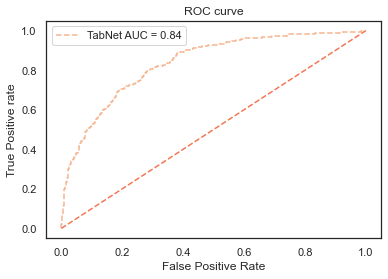

In [96]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',label='TabNet AUC = %0.2f' % auc_score1)
plt.plot(p_fpr, p_tpr, linestyle='--')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show();

In [98]:
features = ['Time Until Discharge',
 'APACHE Score',
 'Sex',
 'Age',
 'Height',
 'Weight',
 'Hour of Admission',
 'Teaching Status',
 'Ethnicity: African American',
 'Ethnicity: Asian',
 'Ethnicity: Caucasian',
 'Ethnicity: Hispanic',
 'Ethnicity: Native American',
 'Ethnicity: Other/Unknown',
 'CCU-CTICU',
 'CSICU',
 'CTICU',
 'Cardiac ICU',
 'MICU',
 'Med-Surg ICU',
 'Neuro ICU',
 'SICU',
 'Admission Source: Acute Care/Floor',
 'Admission Source: Direct Admit',
 'Admission Source: Emergency Department',
 'Admission Source: Floor',
 'Admission Source: Operating Room',
 'Admission Source: Other Hospital',
 'Admission Source: PACU',
 'Admission Source: Recovery Room',
 'Admission Source: Step-Down Unit (SDU)',
 'Admission Source: misc',
 'unitvisitnumber_1',
 'unitvisitnumber_2',
 'unitvisitnumber_3',
 'unitvisitnumber_misc',
 'Admission',
 'Readmission',
 'Transfer',
 'Physician Speciality: Not Specified',
 'Physician Speciality: Cardiology',
 'Physician Speciality: Critical care medicine (CCM)',
 'Physician Speciality: Family practice',
 'Physician Speciality: Hospitalist',
 'Physician Speciality: Internal medicine',
 'Physician Speciality: Misc',
 'Physician Speciality: Neurology',
 'Physician Speciality: Other',
 'Physician Speciality: Pulmonary',
 'Physician Speciality: Pulmonary/CCM',
 'Physician Speciality: Surgery-cardiac',
 'Physician Speciality: Surgery-general',
 'Physician Speciality: Surgery-neuro',
 'Physician Speciality: Surgery-trauma',
 'Physician Speciality: Surgery-vascular',
 'Physician Speciality: Unknown',
 'Number of Beds: 100 - 249',
 'Number of Beds: 250 - 499',
 'Number of Beds: <100',
 'Number of Beds: >= 500',
 'Region: Midwest',
 'Region: Northeast',
 'Region: South',
 'Region: West',
 'Systolic BP_mean',
 'Diastolic BP_mean',
 'Mean BP_mean',
 'Systolic BP_std',
 'Diastolic BP_std',
 'Mean BP_std',
 'Exhaled MV_mean',
 'Exhaled TV (patient)_mean',
 'FiO2_mean',
 'LPM O2_mean',
 'Mean Airway Pressure_mean',
 'PEEP_mean',
 'Peak Insp. Pressure_mean',
 'Plateau Pressure_mean',
 'Pressure Support_mean',
 'RR_mean',
 'SaO2_mean',
 'TV/kg IBW_mean',
 'Tidal Volume_mean',
 'Total RR_mean',
 'Vent Rate_mean',
 'Exhaled MV_std',
 'Exhaled TV_std',
 'FiO2_std',
 'LPM O2_std',
 'Mean Airway Pressure_std',
 'PEEP_std',
 'Peak Insp. Pressure_std',
 'Plateau Pressure_std',
 'Pressure Support_std',
 'RR_std',
 'SaO2_std',
 'TV/kg IBW_std',
 'Tidal Volume_std',
 'Total RR_std',
 'Vent Rate_std',
 'Basos_mean',
 'Eos_mean',
 'Lymphocytes_mean',
 'Monos_mean',
 'Polys_mean',
 'ALT_mean',
 'AST_mean',
 'BUN_mean',
 'Base Excess_mean',
 'FiO2_mean',
 'HCO3_mean',
 'Hct_mean',
 'Hgb_mean',
 'MCH_mean',
 'MCHC_mean',
 'MCV_mean',
 'MPV_mean',
 'O2 Sat_mean',
 'PT_mean',
 'PT - INR_mean',
 'PTT_mean',
 'RBC_mean',
 'RDW_mean',
 'WBC_mean',
 'Albumin_mean',
 'Alkaline phos._mean',
 'Anion gap_mean',
 'Bedside glucose_mean',
 'Bicarbonate_mean',
 'Calcium_mean',
 'Chloride_mean',
 'Creatinine_mean',
 'Glucose_mean',
 'Lactate_mean',
 'Magnesium_mean',
 'pH_mean',
 'paCO2_mean',
 'paO2_mean',
 'Phosphate_mean',
 'Platelets_mean',
 'Potassium_mean',
 'Sodium_mean',
 'Bilirubin_mean',
 'Protein_mean',
 'Troponin_mean',
 'Urinary specific gravity_mean',
 'Basos_std',
 'EOS_std',
 'Lymphocytes_std',
 'Monos_std',
 'Polys_std',
 'ALT_std',
 'AST_std',
 'BUN_std',
 'Base Excess_std',
 'FiO2_std',
 'HCO3_std',
 'Hct_std',
 'Hgb_std',
 'MCH_std',
 'MCHC_std',
 'MCV_std',
 'MPV_std',
 'O2 Sat_std',
 'PT_std',
 'PT - INR_std',
 'PTT_std',
 'RBC_std',
 'RDW_std',
 'WBC_std',
 'Albumin_std',
 'Alkaline phos._std',
 'Anion gap_std',
 'Bedside glucose_std',
 'Bicarbonate_std',
 'Calcium_std',
 'Chloride_std',
 'Creatinine_std',
 'Glucose_std',
 'Lactate_std',
 'Magnesium_std',
 'pH_std',
 'paCO2_std',
 'paO2_std',
 'Phosphate_std',
 'Platelets_std',
 'Potassium_std',
 'Sodium_std',
 'Bilirubin_std',
 'Protein_std',
 'Troponin_std',
 'Urinary specific gravity_std']

In [100]:
feature_importance = pd.DataFrame(list(zip(features, TabNet.feature_importances_)),
              columns=['Feature','Importance'])

In [101]:
feature_importance

,Feature,Importance
0,Time Until Discharge,0.000375
1,APACHE Score,0.285666
2,Sex,0.002161
3,Age,0.000634
4,Height,0.003788
...,...,...
187,Sodium_std,0.002739
188,Bilirubin_std,0.003348
189,Protein_std,0.005523
190,Troponin_std,0.003013


<AxesSubplot:ylabel='Feature'>

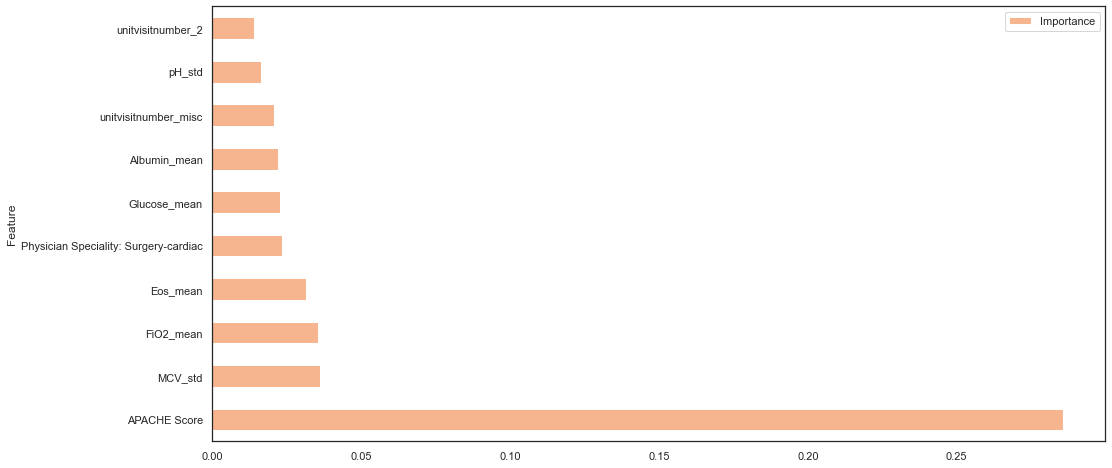

In [110]:
feature_importance.nlargest(10,'Importance').plot(kind='barh',stacked=False, figsize=(16,8), x='Feature')

# Without tuning or pretraining

In [122]:
TabNet = TabNetClassifier()

Device used : cpu


In [123]:
TabNet.fit(X_train_res, np.ravel(y_train))

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.5941  |  0:00:01s
epoch 1  | loss: 0.48637 |  0:00:02s
epoch 2  | loss: 0.4594  |  0:00:03s
epoch 3  | loss: 0.4357  |  0:00:04s
epoch 4  | loss: 0.41695 |  0:00:05s
epoch 5  | loss: 0.41254 |  0:00:05s
epoch 6  | loss: 0.40158 |  0:00:06s
epoch 7  | loss: 0.40115 |  0:00:06s
epoch 8  | loss: 0.39462 |  0:00:07s
epoch 9  | loss: 0.3939  |  0:00:08s
epoch 10 | loss: 0.38653 |  0:00:08s
epoch 11 | loss: 0.38003 |  0:00:09s
epoch 12 | loss: 0.37382 |  0:00:09s
epoch 13 | loss: 0.36826 |  0:00:10s
epoch 14 | loss: 0.36591 |  0:00:10s
epoch 15 | loss: 0.36201 |  0:00:11s
epoch 16 | loss: 0.36283 |  0:00:12s
epoch 17 | loss: 0.3561  |  0:00:13s
epoch 18 | loss: 0.35175 |  0:00:13s
epoch 19 | loss: 0.35094 |  0:00:14s
epoch 20 | loss: 0.35129 |  0:00:15s
epoch 21 | loss: 0.34921 |  0:00:15s
epoch 22 | loss: 0.34427 |  0:00:16s
epoch 23 | loss: 0.3414  |  0:00:18s
epoch 24 | loss: 0.34123 |  0:00:19s
ep

In [124]:
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, TabNet.predict(X_test_res)))
print('Average Precision is:', metrics.average_precision_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, TabNet.predict(X_test_res), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, TabNet.predict(X_test_res)))
print('#################################################')

Results:
AUROC is: 0.8495095124851367
Accuracy is: 0.8674568965517241
Average Precision is: 0.6473113675354312
Weighted F1 is: 0.8597437940857297
Sensitivity is: 0.5201149425287356
#################################################


In [ ]:
feature_importance = pd.DataFrame(list(zip(features, TabNet.feature_importances_)),
              columns=['Feature','Importance'])

<AxesSubplot:ylabel='Feature'>

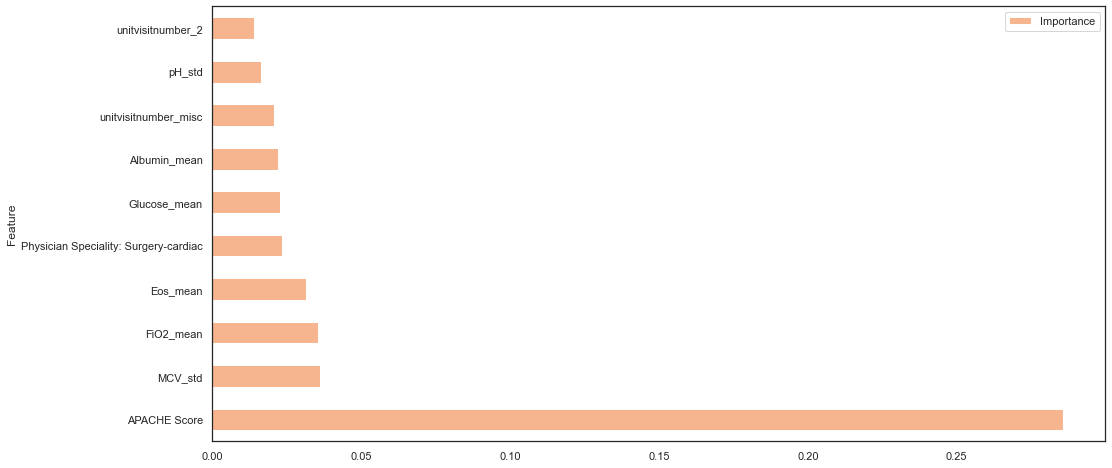

In [125]:
feature_importance.nlargest(10,'Importance').plot(kind='barh',stacked=False, figsize=(16,8), x='Feature')

In [175]:
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, np.ravel(y_train), cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose=1)

[learning_curve] Training set sizes: [  59  179  299  419  539  659  779  899 1019 1139 1259 1379 1499 1619
 1738 1858 1978 2098 2218 2338 2458 2578 2698 2818 2938 3058 3178 3298
 3418 3538 3658 3778 3898 4018 4138 4258 4378 4498 4618 4738 4858 4978
 5098 5218 5338 5458 5578 5698 5818 5938]
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device use

epoch 53 | loss: 0.30423 |  0:00:10s
epoch 54 | loss: 0.29302 |  0:00:11s
epoch 55 | loss: 0.302   |  0:00:11s
epoch 56 | loss: 0.29074 |  0:00:11s
epoch 57 | loss: 0.28398 |  0:00:11s
epoch 58 | loss: 0.29133 |  0:00:11s
epoch 59 | loss: 0.27966 |  0:00:12s
epoch 60 | loss: 0.27235 |  0:00:12s
epoch 61 | loss: 0.26861 |  0:00:12s
epoch 62 | loss: 0.26459 |  0:00:12s
epoch 63 | loss: 0.2737  |  0:00:12s
epoch 64 | loss: 0.27118 |  0:00:13s
epoch 65 | loss: 0.26506 |  0:00:13s
epoch 66 | loss: 0.26231 |  0:00:13s
epoch 67 | loss: 0.26836 |  0:00:13s
epoch 68 | loss: 0.26012 |  0:00:13s
epoch 69 | loss: 0.24793 |  0:00:13s
epoch 70 | loss: 0.24203 |  0:00:14s
epoch 71 | loss: 0.25628 |  0:00:14s
epoch 72 | loss: 0.24929 |  0:00:14s
epoch 73 | loss: 0.24073 |  0:00:14s
epoch 74 | loss: 0.24875 |  0:00:14s
epoch 75 | loss: 0.24101 |  0:00:15s
epoch 76 | loss: 0.25102 |  0:00:15s
epoch 77 | loss: 0.22423 |  0:00:15s
epoch 78 | loss: 0.23711 |  0:00:15s
epoch 79 | loss: 0.22934 |  0:00:15s
e

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.82923 |  0:00:00s
epoch 1  | loss: 0.70431 |  0:00:00s
epoch 2  | loss: 0.64893 |  0:00:00s
epoch 3  | loss: 0.60851 |  0:00:00s
epoch 4  | loss: 0.58254 |  0:00:00s
epoch 5  | loss: 0.56867 |  0:00:00s
epoch 6  | loss: 0.5811  |  0:00:00s
epoch 7  | loss: 0.56202 |  0:00:00s
epoch 8  | loss: 0.53181 |  0:00:00s
epoch 9  | loss: 0.53684 |  0:00:00s
epoch 10 | loss: 0.52142 |  0:00:00s
epoch 11 | loss: 0.4997  |  0:00:00s
epoch 12 | loss: 0.52082 |  0:00:01s
epoch 13 | loss: 0.48597 |  0:00:01s
epoch 14 | loss: 0.48194 |  0:00:01s
epoch 15 | loss: 0.48053 |  0:00:01s
epoch 16 | loss: 0.47516 |  0:00:01s
epoch 17 | loss: 0.46769 |  0:00:01s
epoch 18 | loss: 0.45554 |  0:00:01s
epoch 19 | loss: 0.46456 |  0:00:01s
epoch 20 | loss: 0.47222 |  0:00:01s
epoch 21 | loss: 0.45605 |  0:00:01s
epoch 22 | loss: 0.45202 |  0:00:01s
epoch 23 | loss: 0.45663 |  0:00:01s
epoch 24 | loss: 0.4579  |  0:00:01s
ep

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.66702 |  0:00:00s
epoch 1  | loss: 0.61255 |  0:00:00s
epoch 2  | loss: 0.58492 |  0:00:00s
epoch 3  | loss: 0.56985 |  0:00:00s
epoch 4  | loss: 0.53511 |  0:00:00s
epoch 5  | loss: 0.5446  |  0:00:00s
epoch 6  | loss: 0.558   |  0:00:00s
epoch 7  | loss: 0.54162 |  0:00:00s
epoch 8  | loss: 0.55623 |  0:00:01s
epoch 9  | loss: 0.52768 |  0:00:01s
epoch 10 | loss: 0.50729 |  0:00:01s
epoch 11 | loss: 0.49996 |  0:00:01s
epoch 12 | loss: 0.4893  |  0:00:01s
epoch 13 | loss: 0.47393 |  0:00:01s
epoch 14 | loss: 0.48408 |  0:00:01s
epoch 15 | loss: 0.48208 |  0:00:01s
epoch 16 | loss: 0.47289 |  0:00:01s
epoch 17 | loss: 0.48651 |  0:00:02s
epoch 18 | loss: 0.46033 |  0:00:02s
epoch 19 | loss: 0.47044 |  0:00:02s
epoch 20 | loss: 0.46269 |  0:00:02s
epoch 21 | loss: 0.47562 |  0:00:02s
epoch 22 | loss: 0.45643 |  0:00:02s
epoch 23 | loss: 0.4504  |  0:00:02s
epoch 24 | loss: 0.44694 |  0:00:02s
ep

epoch 50 | loss: 0.32141 |  0:00:33s
epoch 51 | loss: 0.31808 |  0:00:33s
epoch 52 | loss: 0.31123 |  0:00:34s
epoch 53 | loss: 0.31106 |  0:00:34s
epoch 54 | loss: 0.31357 |  0:00:35s
epoch 55 | loss: 0.31297 |  0:00:36s
epoch 56 | loss: 0.30174 |  0:00:36s
epoch 57 | loss: 0.30235 |  0:00:37s
epoch 58 | loss: 0.30049 |  0:00:38s
epoch 59 | loss: 0.29568 |  0:00:38s
epoch 60 | loss: 0.30555 |  0:00:39s
epoch 61 | loss: 0.29385 |  0:00:40s
epoch 62 | loss: 0.29117 |  0:00:40s
epoch 63 | loss: 0.2889  |  0:00:41s
epoch 64 | loss: 0.29117 |  0:00:42s
epoch 65 | loss: 0.29281 |  0:00:42s
epoch 66 | loss: 0.28833 |  0:00:43s
epoch 67 | loss: 0.29259 |  0:00:44s
epoch 68 | loss: 0.29308 |  0:00:44s
epoch 69 | loss: 0.28184 |  0:00:45s
epoch 70 | loss: 0.28605 |  0:00:45s
epoch 71 | loss: 0.28432 |  0:00:46s
epoch 72 | loss: 0.28217 |  0:00:47s
epoch 73 | loss: 0.27952 |  0:00:48s
epoch 74 | loss: 0.27767 |  0:00:49s
epoch 75 | loss: 0.27375 |  0:00:49s
epoch 76 | loss: 0.27453 |  0:00:50s
e

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.96464 |  0:00:00s
epoch 1  | loss: 0.75465 |  0:00:00s
epoch 2  | loss: 0.53633 |  0:00:00s
epoch 3  | loss: 0.48723 |  0:00:00s
epoch 4  | loss: 0.42032 |  0:00:00s
epoch 5  | loss: 0.53677 |  0:00:00s
epoch 6  | loss: 0.39024 |  0:00:00s
epoch 7  | loss: 0.41815 |  0:00:00s
epoch 8  | loss: 0.42605 |  0:00:00s
epoch 9  | loss: 0.43993 |  0:00:00s
epoch 10 | loss: 0.42925 |  0:00:00s
epoch 11 | loss: 0.3754  |  0:00:00s
epoch 12 | loss: 0.30243 |  0:00:00s
epoch 13 | loss: 0.27899 |  0:00:00s
epoch 14 | loss: 0.23553 |  0:00:00s
epoch 15 | loss: 0.21135 |  0:00:00s
epoch 16 | loss: 0.17963 |  0:00:00s
epoch 17 | loss: 0.14548 |  0:00:00s
epoch 18 | loss: 0.12223 |  0:00:00s
epoch 19 | loss: 0.1928  |  0:00:00s
epoch 20 | loss: 0.10551 |  0:00:00s
epoch 21 | loss: 0.10047 |  0:00:00s
epoch 22 | loss: 0.08374 |  0:00:00s
epoch 23 | loss: 0.07694 |  0:00:00s
epoch 24 | loss: 0.06247 |  0:00:00s
ep

epoch 74 | loss: 0.30563 |  0:00:25s
epoch 75 | loss: 0.29979 |  0:00:26s
epoch 76 | loss: 0.28953 |  0:00:26s
epoch 77 | loss: 0.29519 |  0:00:26s
epoch 78 | loss: 0.29665 |  0:00:27s
epoch 79 | loss: 0.29625 |  0:00:27s
epoch 80 | loss: 0.28686 |  0:00:27s
epoch 81 | loss: 0.28064 |  0:00:28s
epoch 82 | loss: 0.2801  |  0:00:28s
epoch 83 | loss: 0.27421 |  0:00:28s
epoch 84 | loss: 0.28494 |  0:00:29s
epoch 85 | loss: 0.27958 |  0:00:29s
epoch 86 | loss: 0.2816  |  0:00:29s
epoch 87 | loss: 0.28119 |  0:00:30s
epoch 88 | loss: 0.27514 |  0:00:30s
epoch 89 | loss: 0.27383 |  0:00:30s
epoch 90 | loss: 0.26798 |  0:00:31s
epoch 91 | loss: 0.26586 |  0:00:31s
epoch 92 | loss: 0.26835 |  0:00:31s
epoch 93 | loss: 0.26545 |  0:00:32s
epoch 94 | loss: 0.24846 |  0:00:32s
epoch 95 | loss: 0.24786 |  0:00:33s
epoch 96 | loss: 0.25348 |  0:00:33s
epoch 97 | loss: 0.25065 |  0:00:33s
epoch 98 | loss: 0.25165 |  0:00:34s
epoch 99 | loss: 0.2497  |  0:00:34s
No early stopping will be performed, l

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.70748 |  0:00:00s
epoch 1  | loss: 0.65668 |  0:00:00s
epoch 2  | loss: 0.61011 |  0:00:00s
epoch 3  | loss: 0.5795  |  0:00:00s
epoch 4  | loss: 0.59    |  0:00:00s
epoch 5  | loss: 0.5698  |  0:00:01s
epoch 6  | loss: 0.5393  |  0:00:01s
epoch 7  | loss: 0.55558 |  0:00:01s
epoch 8  | loss: 0.52665 |  0:00:01s
epoch 9  | loss: 0.53487 |  0:00:01s
epoch 10 | loss: 0.50018 |  0:00:01s
epoch 11 | loss: 0.48626 |  0:00:01s
epoch 12 | loss: 0.51493 |  0:00:01s
epoch 13 | loss: 0.48506 |  0:00:01s
epoch 14 | loss: 0.49309 |  0:00:01s
epoch 15 | loss: 0.46387 |  0:00:01s
epoch 16 | loss: 0.47472 |  0:00:02s
epoch 17 | loss: 0.46622 |  0:00:02s
epoch 18 | loss: 0.46425 |  0:00:02s
epoch 19 | loss: 0.45917 |  0:00:02s
epoch 20 | loss: 0.45993 |  0:00:02s
epoch 21 | loss: 0.44622 |  0:00:02s
epoch 22 | loss: 0.44041 |  0:00:02s
epoch 23 | loss: 0.43984 |  0:00:02s
epoch 24 | loss: 0.435   |  0:00:02s
ep

epoch 36 | loss: 0.37089 |  0:00:17s
epoch 37 | loss: 0.3489  |  0:00:18s
epoch 38 | loss: 0.34536 |  0:00:18s
epoch 39 | loss: 0.35359 |  0:00:19s
epoch 40 | loss: 0.35223 |  0:00:19s
epoch 41 | loss: 0.34134 |  0:00:20s
epoch 42 | loss: 0.34735 |  0:00:20s
epoch 43 | loss: 0.34672 |  0:00:21s
epoch 44 | loss: 0.34632 |  0:00:21s
epoch 45 | loss: 0.33605 |  0:00:21s
epoch 46 | loss: 0.33443 |  0:00:22s
epoch 47 | loss: 0.33298 |  0:00:22s
epoch 48 | loss: 0.32617 |  0:00:23s
epoch 49 | loss: 0.32391 |  0:00:23s
epoch 50 | loss: 0.31561 |  0:00:24s
epoch 51 | loss: 0.30811 |  0:00:24s
epoch 52 | loss: 0.30693 |  0:00:25s
epoch 53 | loss: 0.30967 |  0:00:25s
epoch 54 | loss: 0.31083 |  0:00:26s
epoch 55 | loss: 0.29933 |  0:00:26s
epoch 56 | loss: 0.30454 |  0:00:26s
epoch 57 | loss: 0.30315 |  0:00:27s
epoch 58 | loss: 0.30164 |  0:00:27s
epoch 59 | loss: 0.30099 |  0:00:28s
epoch 60 | loss: 0.2968  |  0:00:28s
epoch 61 | loss: 0.29744 |  0:00:29s
epoch 62 | loss: 0.29063 |  0:00:29s
e

epoch 1  | loss: 0.59936 |  0:00:01s
epoch 2  | loss: 0.51477 |  0:00:02s
epoch 3  | loss: 0.49991 |  0:00:02s
epoch 4  | loss: 0.48015 |  0:00:03s
epoch 5  | loss: 0.46527 |  0:00:03s
epoch 6  | loss: 0.46106 |  0:00:04s
epoch 7  | loss: 0.45091 |  0:00:04s
epoch 8  | loss: 0.43384 |  0:00:05s
epoch 9  | loss: 0.41746 |  0:00:06s
epoch 10 | loss: 0.41714 |  0:00:06s
epoch 11 | loss: 0.40944 |  0:00:07s
epoch 12 | loss: 0.40356 |  0:00:08s
epoch 13 | loss: 0.39866 |  0:00:08s
epoch 14 | loss: 0.39346 |  0:00:09s
epoch 15 | loss: 0.39798 |  0:00:09s
epoch 16 | loss: 0.39612 |  0:00:10s
epoch 17 | loss: 0.40363 |  0:00:11s
epoch 18 | loss: 0.39367 |  0:00:11s
epoch 19 | loss: 0.38678 |  0:00:12s
epoch 20 | loss: 0.38386 |  0:00:13s
epoch 21 | loss: 0.38576 |  0:00:13s
epoch 22 | loss: 0.38906 |  0:00:14s
epoch 23 | loss: 0.37325 |  0:00:15s
epoch 24 | loss: 0.37682 |  0:00:15s
epoch 25 | loss: 0.36546 |  0:00:16s
epoch 26 | loss: 0.36703 |  0:00:16s
epoch 27 | loss: 0.36383 |  0:00:17s
e

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.67977 |  0:00:00s
epoch 1  | loss: 0.635   |  0:00:00s
epoch 2  | loss: 0.59653 |  0:00:00s
epoch 3  | loss: 0.56007 |  0:00:00s
epoch 4  | loss: 0.53058 |  0:00:00s
epoch 5  | loss: 0.52731 |  0:00:00s
epoch 6  | loss: 0.51985 |  0:00:00s
epoch 7  | loss: 0.51675 |  0:00:00s
epoch 8  | loss: 0.49776 |  0:00:00s
epoch 9  | loss: 0.49732 |  0:00:00s
epoch 10 | loss: 0.49499 |  0:00:00s
epoch 11 | loss: 0.49498 |  0:00:00s
epoch 12 | loss: 0.48789 |  0:00:00s
epoch 13 | loss: 0.4672  |  0:00:00s
epoch 14 | loss: 0.47333 |  0:00:00s
epoch 15 | loss: 0.46239 |  0:00:00s
epoch 16 | loss: 0.46679 |  0:00:00s
epoch 17 | loss: 0.46714 |  0:00:00s
epoch 18 | loss: 0.47549 |  0:00:00s
epoch 19 | loss: 0.4309  |  0:00:00s
epoch 20 | loss: 0.45203 |  0:00:00s
epoch 21 | loss: 0.45668 |  0:00:00s
epoch 22 | loss: 0.43361 |  0:00:01s
epoch 23 | loss: 0.43452 |  0:00:01s
epoch 24 | loss: 0.42529 |  0:00:01s
ep

epoch 80 | loss: 0.26897 |  0:00:30s
epoch 81 | loss: 0.26382 |  0:00:30s
epoch 82 | loss: 0.26624 |  0:00:31s
epoch 83 | loss: 0.26888 |  0:00:31s
epoch 84 | loss: 0.25929 |  0:00:31s
epoch 85 | loss: 0.26013 |  0:00:32s
epoch 86 | loss: 0.26224 |  0:00:32s
epoch 87 | loss: 0.25947 |  0:00:33s
epoch 88 | loss: 0.26667 |  0:00:33s
epoch 89 | loss: 0.26415 |  0:00:33s
epoch 90 | loss: 0.25603 |  0:00:34s
epoch 91 | loss: 0.25712 |  0:00:34s
epoch 92 | loss: 0.25286 |  0:00:34s
epoch 93 | loss: 0.25444 |  0:00:35s
epoch 94 | loss: 0.24991 |  0:00:35s
epoch 95 | loss: 0.24566 |  0:00:36s
epoch 96 | loss: 0.2396  |  0:00:36s
epoch 97 | loss: 0.24283 |  0:00:36s
epoch 98 | loss: 0.23931 |  0:00:37s
epoch 99 | loss: 0.22865 |  0:00:37s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.74288 |  0:00:00s
epoch 1  | loss: 0.56329 |  0:00:01s
epoch 2  | loss: 0.53527 |  0:00:01s
epoch 3  | loss: 0.51844 |  0:00:02s
epoch 4  | loss: 0.48261 |  0:00:02s
ep

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.09687 |  0:00:00s
epoch 1  | loss: 0.89684 |  0:00:00s
epoch 2  | loss: 0.74743 |  0:00:00s
epoch 3  | loss: 0.71316 |  0:00:00s
epoch 4  | loss: 0.63343 |  0:00:00s
epoch 5  | loss: 0.59598 |  0:00:00s
epoch 6  | loss: 0.55554 |  0:00:00s
epoch 7  | loss: 0.55846 |  0:00:00s
epoch 8  | loss: 0.56245 |  0:00:00s
epoch 9  | loss: 0.56763 |  0:00:00s
epoch 10 | loss: 0.57537 |  0:00:00s
epoch 11 | loss: 0.56099 |  0:00:00s
epoch 12 | loss: 0.52536 |  0:00:00s
epoch 13 | loss: 0.50269 |  0:00:00s
epoch 14 | loss: 0.53083 |  0:00:00s
epoch 15 | loss: 0.48617 |  0:00:00s
epoch 16 | loss: 0.47476 |  0:00:01s
epoch 17 | loss: 0.47628 |  0:00:01s
epoch 18 | loss: 0.47301 |  0:00:01s
epoch 19 | loss: 0.48372 |  0:00:01s
epoch 20 | loss: 0.46618 |  0:00:01s
epoch 21 | loss: 0.45527 |  0:00:01s
epoch 22 | loss: 0.44798 |  0:00:01s
epoch 23 | loss: 0.44973 |  0:00:01s
epoch 24 | loss: 0.45194 |  0:00:01s
ep

epoch 21 | loss: 0.39207 |  0:00:10s
epoch 22 | loss: 0.40001 |  0:00:10s
epoch 23 | loss: 0.39552 |  0:00:10s
epoch 24 | loss: 0.39215 |  0:00:11s
epoch 25 | loss: 0.39737 |  0:00:11s
epoch 26 | loss: 0.39395 |  0:00:11s
epoch 27 | loss: 0.38775 |  0:00:12s
epoch 28 | loss: 0.3953  |  0:00:12s
epoch 29 | loss: 0.37999 |  0:00:13s
epoch 30 | loss: 0.38617 |  0:00:13s
epoch 31 | loss: 0.38616 |  0:00:13s


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 115.7min finished


epoch 32 | loss: 0.34102 |  0:00:25s
epoch 33 | loss: 0.337   |  0:00:26s
epoch 34 | loss: 0.33174 |  0:00:26s
epoch 35 | loss: 0.32254 |  0:00:27s
epoch 36 | loss: 0.32168 |  0:00:28s
epoch 37 | loss: 0.31839 |  0:00:28s
epoch 38 | loss: 0.32229 |  0:00:29s
epoch 39 | loss: 0.31715 |  0:00:30s
epoch 40 | loss: 0.30673 |  0:00:30s
epoch 41 | loss: 0.31634 |  0:00:31s
epoch 42 | loss: 0.31349 |  0:00:32s
epoch 43 | loss: 0.30893 |  0:00:32s
epoch 44 | loss: 0.30217 |  0:00:33s
epoch 45 | loss: 0.30076 |  0:00:34s
epoch 46 | loss: 0.30176 |  0:00:35s
epoch 47 | loss: 0.30199 |  0:00:35s
epoch 48 | loss: 0.29664 |  0:00:36s
epoch 49 | loss: 0.29662 |  0:00:37s
epoch 50 | loss: 0.28972 |  0:00:38s
epoch 51 | loss: 0.28507 |  0:00:38s
epoch 52 | loss: 0.28748 |  0:00:39s
epoch 53 | loss: 0.28447 |  0:00:40s
epoch 54 | loss: 0.2851  |  0:00:40s
epoch 55 | loss: 0.27779 |  0:00:41s
epoch 56 | loss: 0.28132 |  0:00:42s
epoch 57 | loss: 0.27439 |  0:00:43s
epoch 58 | loss: 0.28035 |  0:00:43s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

poch 59 | loss: 0.2781  |  0:00:44s
epoch 60 | loss: 0.27367 |  0:00:45s
epoch 61 | loss: 0.26778 |  0:00:45s
epoch 62 | loss: 0.26323 |  0:00:46s
epoch 63 | loss: 0.26438 |  0:00:47s
epoch 64 | loss: 0.25935 |  0:00:47s
epoch 65 | loss: 0.25355 |  0:00:48s
epoch 66 | loss: 0.25379 |  0:00:49s
epoch 67 | loss: 0.25379 |  0:00:49s
epoch 68 | loss: 0.26159 |  0:00:50s
epoch 69 | loss: 0.25418 |  0:00:51s
epoch 70 | loss: 0.25062 |  0:00:51s
epoch 71 | loss: 0.25129 |  0:00:52s
epoch 72 | loss: 0.24315 |  0:00:53s
epoch 73 | loss: 0.24623 |  0:00:53s
epoch 74 | loss: 0.24777 |  0:00:54s
epoch 75 | loss: 0.24868 |  0:00:55s
epoch 76 | loss: 0.23961 |  0:00:56s
epoch 77 | loss: 0.23542 |  0:00:56s
epoch 78 | loss: 0.23742 |  0:00:57s
epoch 79 | loss: 0.22846 |  0:00:58s
epoch 80 | loss: 0.23829 |  0:00:58s
epoch 81 | loss: 0.23413 |  0:00:59s
epoch 82 | loss: 0.22884 |  0:01:00s
epoch 83 | loss: 0.22563 |  0:01:00s
epoch 84 | loss: 0.22263 |  0:01:01s
epoch 85 | loss: 0.22182 |  0:01:02s
ep

 stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


och 86 | loss: 0.21837 |  0:01:03s
epoch 87 | loss: 0.22188 |  0:01:03s
epoch 88 | loss: 0.22189 |  0:01:04s
epoch 89 | loss: 0.2151  |  0:01:05s
epoch 90 | loss: 0.21844 |  0:01:06s
epoch 91 | loss: 0.21355 |  0:01:06s
epoch 92 | loss: 0.21782 |  0:01:07s
epoch 93 | loss: 0.22578 |  0:01:08s
epoch 94 | loss: 0.22124 |  0:01:08s
epoch 95 | loss: 0.21306 |  0:01:09s
epoch 96 | loss: 0.21772 |  0:01:10s
epoch 97 | loss: 0.2077  |  0:01:10s
epoch 98 | loss: 0.21564 |  0:01:11s
epoch 99 | loss: 0.20031 |  0:01:12s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.9715  |  0:00:00s
epoch 1  | loss: 0.64572 |  0:00:00s
epoch 2  | loss: 0.59077 |  0:00:00s
epoch 3  | loss: 0.58237 |  0:00:00s
epoch 4  | loss: 0.54631 |  0:00:01s
epoch 5  | loss: 0.55228 |  0:00:01s
epoch 6  | loss: 0.50105 |  0:00:01s
epoch 7  | loss: 0.49646 |  0:00:01s
epoch 8  | loss: 0.48084 |  0:00:01s
epoch 9  | loss: 0.46602 |  0:00:01s
epoch 10 | loss: 0.45206 |  0:00:02s
epoc

epoch 32 | loss: 0.34521 |  0:00:05s
epoch 33 | loss: 0.34005 |  0:00:06s
epoch 34 | loss: 0.33701 |  0:00:06s
epoch 35 | loss: 0.32987 |  0:00:06s
epoch 36 | loss: 0.32116 |  0:00:06s
epoch 37 | loss: 0.33472 |  0:00:06s
epoch 38 | loss: 0.33592 |  0:00:06s
epoch 39 | loss: 0.33057 |  0:00:07s
epoch 40 | loss: 0.33016 |  0:00:07s
epoch 41 | loss: 0.3263  |  0:00:07s
epoch 42 | loss: 0.32279 |  0:00:07s
epoch 43 | loss: 0.31726 |  0:00:07s
epoch 44 | loss: 0.32311 |  0:00:07s
epoch 45 | loss: 0.32411 |  0:00:08s
epoch 46 | loss: 0.31459 |  0:00:08s
epoch 47 | loss: 0.32906 |  0:00:08s
epoch 48 | loss: 0.32674 |  0:00:08s
epoch 49 | loss: 0.31562 |  0:00:08s
epoch 50 | loss: 0.30385 |  0:00:08s
epoch 51 | loss: 0.31482 |  0:00:09s
epoch 52 | loss: 0.31768 |  0:00:09s
epoch 53 | loss: 0.30887 |  0:00:09s
epoch 54 | loss: 0.33339 |  0:00:09s
epoch 55 | loss: 0.31653 |  0:00:09s
epoch 56 | loss: 0.31634 |  0:00:09s
epoch 57 | loss: 0.31728 |  0:00:09s
epoch 58 | loss: 0.31466 |  0:00:10s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

epoch 32 | loss: 0.36049 |  0:00:01s
epoch 33 | loss: 0.34119 |  0:00:01s
epoch 34 | loss: 0.35716 |  0:00:01s
epoch 35 | loss: 0.33969 |  0:00:01s
epoch 36 | loss: 0.30458 |  0:00:01s
epoch 37 | loss: 0.30813 |  0:00:01s
epoch 38 | loss: 0.30708 |  0:00:01s
epoch 39 | loss: 0.34349 |  0:00:02s
epoch 40 | loss: 0.29117 |  0:00:02s
epoch 41 | loss: 0.31094 |  0:00:02s
epoch 42 | loss: 0.33526 |  0:00:02s
epoch 43 | loss: 0.29564 |  0:00:02s
epoch 44 | loss: 0.32391 |  0:00:02s
epoch 45 | loss: 0.32223 |  0:00:02s
epoch 46 | loss: 0.30615 |  0:00:02s
epoch 47 | loss: 0.32763 |  0:00:02s
epoch 48 | loss: 0.31352 |  0:00:02s
epoch 49 | loss: 0.36579 |  0:00:02s
epoch 50 | loss: 0.34811 |  0:00:02s
epoch 51 | loss: 0.29117 |  0:00:02s
epoch 52 | loss: 0.2877  |  0:00:02s
epoch 53 | loss: 0.28372 |  0:00:02s
epoch 54 | loss: 0.2819  |  0:00:02s
epoch 55 | loss: 0.2874  |  0:00:02s
epoch 56 | loss: 0.24534 |  0:00:02s
epoch 57 | loss: 0.22128 |  0:00:02s
epoch 58 | loss: 0.24208 |  0:00:02s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

epoch 32 | loss: 0.35933 |  0:00:16s
epoch 33 | loss: 0.35601 |  0:00:17s
epoch 34 | loss: 0.35368 |  0:00:17s
epoch 35 | loss: 0.3498  |  0:00:18s
epoch 36 | loss: 0.34521 |  0:00:18s
epoch 37 | loss: 0.34945 |  0:00:19s
epoch 38 | loss: 0.34117 |  0:00:19s
epoch 39 | loss: 0.34631 |  0:00:20s
epoch 40 | loss: 0.34246 |  0:00:20s
epoch 41 | loss: 0.34309 |  0:00:21s
epoch 42 | loss: 0.34007 |  0:00:21s
epoch 43 | loss: 0.33294 |  0:00:22s
epoch 44 | loss: 0.34464 |  0:00:22s
epoch 45 | loss: 0.33483 |  0:00:23s
epoch 46 | loss: 0.3316  |  0:00:23s
epoch 47 | loss: 0.32995 |  0:00:24s
epoch 48 | loss: 0.3239  |  0:00:24s
epoch 49 | loss: 0.32025 |  0:00:25s
epoch 50 | loss: 0.31324 |  0:00:25s
epoch 51 | loss: 0.31248 |  0:00:26s
epoch 52 | loss: 0.30925 |  0:00:26s
epoch 53 | loss: 0.29526 |  0:00:27s
epoch 54 | loss: 0.29703 |  0:00:28s
epoch 55 | loss: 0.29716 |  0:00:28s
epoch 56 | loss: 0.28673 |  0:00:29s
epoch 57 | loss: 0.29367 |  0:00:29s
epoch 58 | loss: 0.28997 |  0:00:30s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

epoch 32 | loss: 0.37574 |  0:00:14s
epoch 33 | loss: 0.38278 |  0:00:14s
epoch 34 | loss: 0.37374 |  0:00:14s
epoch 35 | loss: 0.38373 |  0:00:15s
epoch 36 | loss: 0.37576 |  0:00:15s
epoch 37 | loss: 0.38697 |  0:00:16s
epoch 38 | loss: 0.3839  |  0:00:16s
epoch 39 | loss: 0.38473 |  0:00:16s
epoch 40 | loss: 0.38621 |  0:00:17s
epoch 41 | loss: 0.38555 |  0:00:17s
epoch 42 | loss: 0.37896 |  0:00:18s
epoch 43 | loss: 0.37642 |  0:00:18s
epoch 44 | loss: 0.37574 |  0:00:18s
epoch 45 | loss: 0.37365 |  0:00:19s
epoch 46 | loss: 0.37165 |  0:00:19s
epoch 47 | loss: 0.3738  |  0:00:19s
epoch 48 | loss: 0.3695  |  0:00:20s
epoch 49 | loss: 0.35436 |  0:00:20s
epoch 50 | loss: 0.37217 |  0:00:21s
epoch 51 | loss: 0.36043 |  0:00:21s
epoch 52 | loss: 0.3637  |  0:00:21s
epoch 53 | loss: 0.36119 |  0:00:22s
epoch 54 | loss: 0.36118 |  0:00:22s
epoch 55 | loss: 0.36417 |  0:00:22s
epoch 56 | loss: 0.36408 |  0:00:23s
epoch 57 | loss: 0.36196 |  0:00:23s
epoch 58 | loss: 0.35729 |  0:00:24s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

epoch 32 | loss: 0.37407 |  0:00:06s
epoch 33 | loss: 0.36657 |  0:00:06s
epoch 34 | loss: 0.37585 |  0:00:06s
epoch 35 | loss: 0.37538 |  0:00:06s
epoch 36 | loss: 0.38194 |  0:00:06s
epoch 37 | loss: 0.3663  |  0:00:07s
epoch 38 | loss: 0.37391 |  0:00:07s
epoch 39 | loss: 0.36642 |  0:00:07s
epoch 40 | loss: 0.37708 |  0:00:07s
epoch 41 | loss: 0.38238 |  0:00:07s
epoch 42 | loss: 0.3739  |  0:00:08s
epoch 43 | loss: 0.3804  |  0:00:08s
epoch 44 | loss: 0.3638  |  0:00:08s
epoch 45 | loss: 0.36267 |  0:00:08s
epoch 46 | loss: 0.36659 |  0:00:08s
epoch 47 | loss: 0.3611  |  0:00:08s
epoch 48 | loss: 0.36244 |  0:00:09s
epoch 49 | loss: 0.37356 |  0:00:09s
epoch 50 | loss: 0.36287 |  0:00:09s
epoch 51 | loss: 0.34979 |  0:00:09s
epoch 52 | loss: 0.36278 |  0:00:09s
epoch 53 | loss: 0.34952 |  0:00:10s
epoch 54 | loss: 0.36297 |  0:00:10s
epoch 55 | loss: 0.35231 |  0:00:10s
epoch 56 | loss: 0.33434 |  0:00:10s
epoch 57 | loss: 0.33294 |  0:00:10s
epoch 58 | loss: 0.3461  |  0:00:10s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

epoch 32 | loss: 0.35821 |  0:00:24s
epoch 33 | loss: 0.35398 |  0:00:25s
epoch 34 | loss: 0.35766 |  0:00:26s
epoch 35 | loss: 0.35441 |  0:00:27s
epoch 36 | loss: 0.34955 |  0:00:27s
epoch 37 | loss: 0.34737 |  0:00:28s
epoch 38 | loss: 0.3477  |  0:00:29s
epoch 39 | loss: 0.3549  |  0:00:29s
epoch 40 | loss: 0.34607 |  0:00:30s
epoch 41 | loss: 0.3437  |  0:00:31s
epoch 42 | loss: 0.34385 |  0:00:32s
epoch 43 | loss: 0.34196 |  0:00:32s
epoch 44 | loss: 0.34125 |  0:00:33s
epoch 45 | loss: 0.33959 |  0:00:34s
epoch 46 | loss: 0.34542 |  0:00:35s
epoch 47 | loss: 0.33661 |  0:00:35s
epoch 48 | loss: 0.33233 |  0:00:36s
epoch 49 | loss: 0.33262 |  0:00:37s
epoch 50 | loss: 0.32847 |  0:00:37s
epoch 51 | loss: 0.33498 |  0:00:38s
epoch 52 | loss: 0.32908 |  0:00:39s
epoch 53 | loss: 0.33178 |  0:00:39s
epoch 54 | loss: 0.3262  |  0:00:40s
epoch 55 | loss: 0.33064 |  0:00:41s
epoch 56 | loss: 0.32348 |  0:00:42s
epoch 57 | loss: 0.32381 |  0:00:42s
epoch 58 | loss: 0.32017 |  0:00:43s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

epoch 32 | loss: 0.32547 |  0:00:24s
epoch 33 | loss: 0.32424 |  0:00:24s
epoch 34 | loss: 0.32904 |  0:00:25s
epoch 35 | loss: 0.31586 |  0:00:26s
epoch 36 | loss: 0.31138 |  0:00:27s
epoch 37 | loss: 0.31273 |  0:00:27s
epoch 38 | loss: 0.3089  |  0:00:28s
epoch 39 | loss: 0.30735 |  0:00:29s
epoch 40 | loss: 0.29465 |  0:00:29s
epoch 41 | loss: 0.29911 |  0:00:30s
epoch 42 | loss: 0.29775 |  0:00:31s
epoch 43 | loss: 0.29698 |  0:00:31s
epoch 44 | loss: 0.2939  |  0:00:32s
epoch 45 | loss: 0.29442 |  0:00:33s
epoch 46 | loss: 0.28547 |  0:00:33s
epoch 47 | loss: 0.29019 |  0:00:34s
epoch 48 | loss: 0.28724 |  0:00:35s
epoch 49 | loss: 0.27919 |  0:00:36s
epoch 50 | loss: 0.27685 |  0:00:36s
epoch 51 | loss: 0.27804 |  0:00:37s
epoch 52 | loss: 0.27305 |  0:00:37s
epoch 53 | loss: 0.27138 |  0:00:38s
epoch 54 | loss: 0.26843 |  0:00:39s
epoch 55 | loss: 0.26781 |  0:00:40s
epoch 56 | loss: 0.26635 |  0:00:40s
epoch 57 | loss: 0.26223 |  0:00:41s
epoch 58 | loss: 0.2631  |  0:00:42s
e

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not r

In [176]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [178]:
test_mean

array([0.52024569, 0.59274348, 0.56845795, 0.63721904, 0.57664206,
       0.637782  , 0.65902282, 0.73718568, 0.68300116, 0.78245794,
       0.78532132, 0.78248699, 0.793746  , 0.76648337, 0.7913755 ,
       0.80736817, 0.78759757, 0.83086786, 0.839462  , 0.82709036,
       0.80964628, 0.826798  , 0.83312264, 0.82578448, 0.8435956 ,
       0.84401952, 0.85861678, 0.86751997, 0.84330725, 0.85233051,
       0.84773322, 0.84579792, 0.85162869, 0.84271167, 0.85764711,
       0.86578526, 0.85304522, 0.85939379, 0.86067782, 0.85777682,
       0.85438123, 0.86030167, 0.85173222, 0.86137625, 0.86169744,
       0.85887223, 0.8587452 , 0.85610145, 0.85941265, 0.86840542])

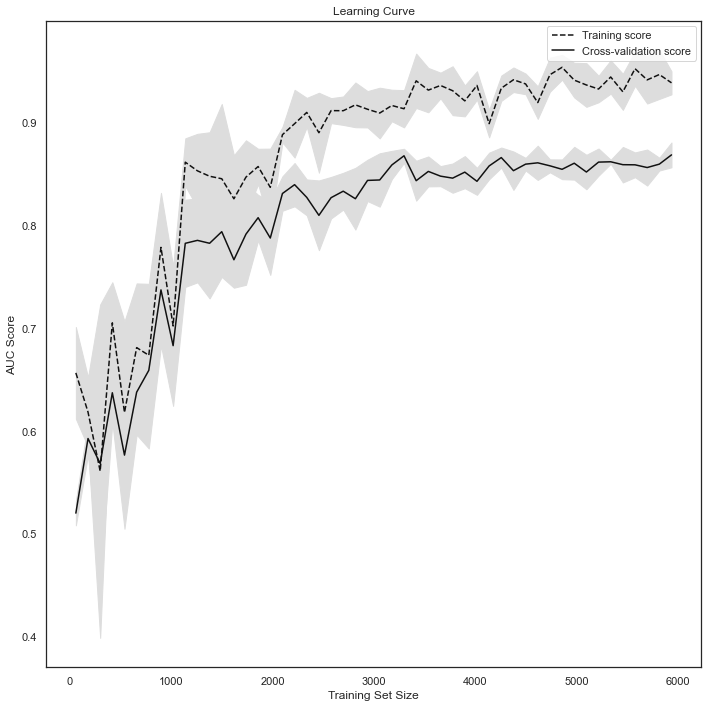

In [177]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("AUC Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Pretraining

In [ ]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer()

In [ ]:
unsupervised_model.fit(X_train = X_train_res,
    max_epochs=1000, patience=5,
    pretraining_ratio=0.8)

In [ ]:
TabNet = TabNetClassifier()

In [ ]:
TabNet.fit(
    X_train=X_train_res, y_train=np.ravel(y_train),
    max_epochs=100,
    from_unsupervised=unsupervised_model) 

In [ ]:
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, TabNet.predict(X_test_res)))
print('Average Precision is:', metrics.average_precision_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, TabNet.predict(X_test_res), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, TabNet.predict(X_test_res)))
print('#################################################')

# Secondary MI Prediction

In [189]:
# MI prediction
X_train = np.load('X_train_static_MI.npy')
X_test = np.load('X_test_static_MI.npy')
y_train = np.load('y_train_static_MI.npy')
y_test = np.load('y_test_static_MI.npy')

In [190]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(X_train)
X_train_res = imp_mean.transform(X_train)
X_test_res = imp_mean.transform(X_test)

[IterativeImputer] Early stopping criterion not reached.


In [182]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [183]:
# Define the imputation and tuning pipeline
TabNet = TabNetClassifier()
imputer = IterativeImputer()
scaler = preprocessing.StandardScaler()
pipeline = Pipeline(steps=[('i', imputer), ('m', TabNet)])

Device used : cpu


In [130]:
# Function that instantiates a tabnet model.
def create_tabnet(n_d=32, n_steps=5, optimizer_params=0.02, gamma=1.5, 
                  n_independent=2, n_shared=2, lambda_sparse=1e-4, 
                  momentum=0.3, clip_value=2.):
    
    model = TabNetClassifier(
        n_d=n_d, n_a=n_d, n_steps=n_steps,
        optimizer_params=optimizer_params,
        gamma=gamma, n_independent=n_independent, n_shared=n_shared,
        lambda_sparse=lambda_sparse, momentum=momentum, clip_value=clip_value,
        optimizer_fn=torch.optim.Adam,
        scheduler_params = {"gamma": 0.95,
                         "step_size": 20},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15, verbose = 0
    )
    return model

In [131]:
# Generate the parameter grid.
param_grid = dict(n_d = [8, 16, 24, 32, 64],
                  n_a = n_d,
                  n_steps = [3, 4, 5],
                  optimizer_params = [dict(lr=0.01), dict(lr=0.02), dict(lr=2e-3), dict(lr=1e-3), dict(lr=1e-4)],     
)

grid = ParameterGrid(param_grid)


search_results = pd.DataFrame() 
for params in grid:
    params['n_a'] = params['n_d'] # n_a=n_d always per the paper
    tabnet = create_tabnet()
    tabnet.set_params(**params)
    scores = []
    for train_ix, test_ix in cv.split(X_train, y_train):
        # split data
        X_train_2, X_test_2 = X_train[train_ix, :], X_train[test_ix, :]
        y_train_2, y_test_2 = y_train[train_ix], y_train[test_ix]
        
        imp_mean_2 = IterativeImputer(random_state=0)
        imp_mean_2.fit(X_train_2)
        X_train_2 = imp_mean_2.transform(X_train_2)
        X_test_2 = imp_mean_2.transform(X_test_2)
        
        tabnet.fit(X_train=X_train_2, y_train=y_train_2)

        y_prob = tabnet.predict_proba(X_test_2)[:,1]
        score = roc_auc_score(y_test_2, y_prob)
        scores.append(score)
    print('For: ', params)
    print('Score is: ', np.mean(scores))
    results = pd.DataFrame([params])
    results['score'] = np.round(np.mean(scores), 3)
    search_results = search_results.append(results)

No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8474813275663318


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8434037514939977


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7495277542834289


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7155681510943724


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5624850961183337


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 4, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8250580604098756


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 4, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8493733621033014


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 4, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7127329764145027


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 4, 'optimizer_params': {'lr': 0.001}}
Score is:  0.6512392597920849


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 4, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5195936197989462


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 5, 'optimizer_params': {'lr': 0.01}}
Score is:  0.7934593953148086


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 5, 'optimizer_params': {'lr': 0.02}}
Score is:  0.814071018027669


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 5, 'optimizer_params': {'lr': 0.002}}
Score is:  0.6937934020810581


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 5, 'optimizer_params': {'lr': 0.001}}
Score is:  0.6638138132964361


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 5, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5476111981347639


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 3, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8670469122490371


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 3, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8791743228568834


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 3, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7904871481759683


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 3, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7312749754308768


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 3, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5588872424009159


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 4, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8369452176014927


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 4, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8662753383017117


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 4, 'optimizer_params': {'lr': 0.002}}
Score is:  0.723322514939054


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 4, 'optimizer_params': {'lr': 0.001}}
Score is:  0.703102478790661


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 4, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5515354205525366


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 5, 'optimizer_params': {'lr': 0.01}}
Score is:  0.7940364920017118


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 5, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8061473717865099


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 5, 'optimizer_params': {'lr': 0.002}}
Score is:  0.6995333306164148


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 5, 'optimizer_params': {'lr': 0.001}}
Score is:  0.6757960879095191


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 16, 'n_d': 16, 'n_steps': 5, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5423642035086658


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 3, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8880972067079564


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 3, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8777922746598256


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 3, 'optimizer_params': {'lr': 0.002}}
Score is:  0.8035841011049787


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 3, 'optimizer_params': {'lr': 0.001}}
Score is:  0.735894752720132


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 3, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5591987168487509


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 4, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8454601312122488


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 4, 'optimizer_params': {'lr': 0.02}}
Score is:  0.848667570238109


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 4, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7319911272007424


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 4, 'optimizer_params': {'lr': 0.001}}
Score is:  0.6833647680957073


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 4, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5219553773506111


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 5, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8064013422776689


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 5, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8460982011547105


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 5, 'optimizer_params': {'lr': 0.002}}
Score is:  0.6893861454393071


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 5, 'optimizer_params': {'lr': 0.001}}
Score is:  0.6637470116202927


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 24, 'n_d': 24, 'n_steps': 5, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5466811672389262


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 3, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8781314209878894


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 3, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8878274363632187


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 3, 'optimizer_params': {'lr': 0.002}}
Score is:  0.8058943434910105


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 3, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7427467302570128


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 3, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5628325449810688


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 4, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8524344777510668


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 4, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8679648789389092


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 4, 'optimizer_params': {'lr': 0.002}}
Score is:  0.735078720906754


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 4, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7142366752906917


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 4, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5455433639796204


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 5, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8204048875487885


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 5, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8765804536688055


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 5, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7259991231749059


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 5, 'optimizer_params': {'lr': 0.001}}
Score is:  0.6787048769732562


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 32, 'n_d': 32, 'n_steps': 5, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.540272665565815


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 3, 'optimizer_params': {'lr': 0.01}}
Score is:  0.890687127599962


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 3, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8907476264710953


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 3, 'optimizer_params': {'lr': 0.002}}
Score is:  0.8453410001021574


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 3, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7967138908462388


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 3, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5893629265877244


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 4, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8758778070365452


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 4, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8846574272909866


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 4, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7782226557298626


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 4, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7288756339553369


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 4, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5706754693365227


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 5, 'optimizer_params': {'lr': 0.01}}
Score is:  0.834890558213892


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 5, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8599625387372305


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 5, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7377614984080734


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 5, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7123682094642987


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 64, 'n_d': 64, 'n_steps': 5, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.571108285831081


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8474813275663318


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8434037514939977


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.002}}
Score is:  0.7495277542834289


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.001}}
Score is:  0.7155681510943724


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 3, 'optimizer_params': {'lr': 0.0001}}
Score is:  0.5624850961183337


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 4, 'optimizer_params': {'lr': 0.01}}
Score is:  0.8250580604098756


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
For:  {'n_a': 8, 'n_d': 8, 'n_steps': 4, 'optimizer_params': {'lr': 0.02}}
Score is:  0.8493733621033014


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


No early stopping will be performed, last training weights will be used.


[IterativeImputer] Early stopping criterion not reached.


No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.


KeyboardInterrupt: 

In [132]:
search_results.iloc[search_results['score'].argmax()]

n_a                           64
n_d                           64
n_steps                        3
optimizer_params    {'lr': 0.01}
score                      0.891
Name: 0, dtype: object

n_a                           64
n_d                           64
n_steps                        3
optimizer_params    {'lr': 0.01}
score                      0.891

In [133]:
TabNet = create_tabnet(n_d = 64, n_steps = 3, optimizer_params=dict(lr=0.01))

In [134]:
TabNet.fit(X_train_res, np.ravel(y_train))

No early stopping will be performed, last training weights will be used.


In [135]:
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, TabNet.predict(X_test_res)))
print('Average Precision is:', metrics.average_precision_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, TabNet.predict(X_test_res), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, TabNet.predict(X_test_res)))
print('#################################################')

Results:
AUROC is: 0.7904137529137529
Accuracy is: 0.7294713160854893
Average Precision is: 0.7824017368345633
Weighted F1 is: 0.7294166318943691
Sensitivity is: 0.7
#################################################


In [136]:
# Compute ROC curve and ROC area for each class
y_score = TabNet.predict_proba(X_test_res)[:,1]
fpr1, tpr1, thresh1 = roc_curve(y_test, y_score, pos_label=1)
# auc scores
auc_score1 = roc_auc_score(y_test, y_score)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

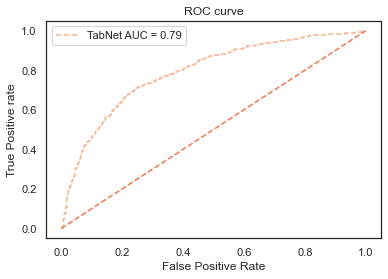

In [137]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',label='TabNet AUC = %0.2f' % auc_score1)
plt.plot(p_fpr, p_tpr, linestyle='--')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show();

In [138]:
features = ['Time Until Discharge',
 'APACHE Score',
 'Sex',
 'Age',
 'Height',
 'Weight',
 'Hour of Admission',
 'Teaching Status',
 'Ethnicity: African American',
 'Ethnicity: Asian',
 'Ethnicity: Caucasian',
 'Ethnicity: Hispanic',
 'Ethnicity: Native American',
 'Ethnicity: Other/Unknown',
 'CCU-CTICU',
 'CSICU',
 'CTICU',
 'Cardiac ICU',
 'MICU',
 'Med-Surg ICU',
 'Neuro ICU',
 'SICU',
 'Admission Source: Acute Care/Floor',
 'Admission Source: Direct Admit',
 'Admission Source: Emergency Department',
 'Admission Source: Floor',
 'Admission Source: Operating Room',
 'Admission Source: Other Hospital',
 'Admission Source: PACU',
 'Admission Source: Recovery Room',
 'Admission Source: Step-Down Unit (SDU)',
 'Admission Source: misc',
 'unitvisitnumber_1',
 'unitvisitnumber_2',
 'unitvisitnumber_3',
 'unitvisitnumber_misc',
 'Admission',
 'Readmission',
 'Transfer',
 'Physician Speciality: Not Specified',
 'Physician Speciality: Cardiology',
 'Physician Speciality: Critical care medicine (CCM)',
 'Physician Speciality: Family practice',
 'Physician Speciality: Hospitalist',
 'Physician Speciality: Internal medicine',
 'Physician Speciality: Misc',
 'Physician Speciality: Neurology',
 'Physician Speciality: Other',
 'Physician Speciality: Pulmonary',
 'Physician Speciality: Pulmonary/CCM',
 'Physician Speciality: Surgery-cardiac',
 'Physician Speciality: Surgery-general',
 'Physician Speciality: Surgery-neuro',
 'Physician Speciality: Surgery-trauma',
 'Physician Speciality: Surgery-vascular',
 'Physician Speciality: Unknown',
 'Number of Beds: 100 - 249',
 'Number of Beds: 250 - 499',
 'Number of Beds: <100',
 'Number of Beds: >= 500',
 'Region: Midwest',
 'Region: Northeast',
 'Region: South',
 'Region: West',
 'Systolic BP_mean',
 'Diastolic BP_mean',
 'Mean BP_mean',
 'Systolic BP_std',
 'Diastolic BP_std',
 'Mean BP_std',
 'Exhaled MV_mean',
 'Exhaled TV (patient)_mean',
 'FiO2_mean',
 'LPM O2_mean',
 'Mean Airway Pressure_mean',
 'PEEP_mean',
 'Peak Insp. Pressure_mean',
 'Plateau Pressure_mean',
 'Pressure Support_mean',
 'RR_mean',
 'SaO2_mean',
 'TV/kg IBW_mean',
 'Tidal Volume_mean',
 'Total RR_mean',
 'Vent Rate_mean',
 'Exhaled MV_std',
 'Exhaled TV_std',
 'FiO2_std',
 'LPM O2_std',
 'Mean Airway Pressure_std',
 'PEEP_std',
 'Peak Insp. Pressure_std',
 'Plateau Pressure_std',
 'Pressure Support_std',
 'RR_std',
 'SaO2_std',
 'TV/kg IBW_std',
 'Tidal Volume_std',
 'Total RR_std',
 'Vent Rate_std',
 'Basos_mean',
 'Eos_mean',
 'Lymphocytes_mean',
 'Monos_mean',
 'Polys_mean',
 'ALT_mean',
 'AST_mean',
 'BUN_mean',
 'Base Excess_mean',
 'FiO2_mean',
 'HCO3_mean',
 'Hct_mean',
 'Hgb_mean',
 'MCH_mean',
 'MCHC_mean',
 'MCV_mean',
 'MPV_mean',
 'O2 Sat_mean',
 'PT_mean',
 'PT - INR_mean',
 'PTT_mean',
 'RBC_mean',
 'RDW_mean',
 'WBC_mean',
 'Albumin_mean',
 'Alkaline phos._mean',
 'Anion gap_mean',
 'Bedside glucose_mean',
 'Bicarbonate_mean',
 'Calcium_mean',
 'Chloride_mean',
 'Creatinine_mean',
 'Glucose_mean',
 'Lactate_mean',
 'Magnesium_mean',
 'pH_mean',
 'paCO2_mean',
 'paO2_mean',
 'Phosphate_mean',
 'Platelets_mean',
 'Potassium_mean',
 'Sodium_mean',
 'Bilirubin_mean',
 'Protein_mean',
 'Troponin_mean',
 'Urinary specific gravity_mean',
 'Basos_std',
 'EOS_std',
 'Lymphocytes_std',
 'Monos_std',
 'Polys_std',
 'ALT_std',
 'AST_std',
 'BUN_std',
 'Base Excess_std',
 'FiO2_std',
 'HCO3_std',
 'Hct_std',
 'Hgb_std',
 'MCH_std',
 'MCHC_std',
 'MCV_std',
 'MPV_std',
 'O2 Sat_std',
 'PT_std',
 'PT - INR_std',
 'PTT_std',
 'RBC_std',
 'RDW_std',
 'WBC_std',
 'Albumin_std',
 'Alkaline phos._std',
 'Anion gap_std',
 'Bedside glucose_std',
 'Bicarbonate_std',
 'Calcium_std',
 'Chloride_std',
 'Creatinine_std',
 'Glucose_std',
 'Lactate_std',
 'Magnesium_std',
 'pH_std',
 'paCO2_std',
 'paO2_std',
 'Phosphate_std',
 'Platelets_std',
 'Potassium_std',
 'Sodium_std',
 'Bilirubin_std',
 'Protein_std',
 'Troponin_std',
 'Urinary specific gravity_std']

In [139]:
feature_importance = pd.DataFrame(list(zip(features, TabNet.feature_importances_)),
              columns=['Feature','Importance'])

<AxesSubplot:ylabel='Feature'>

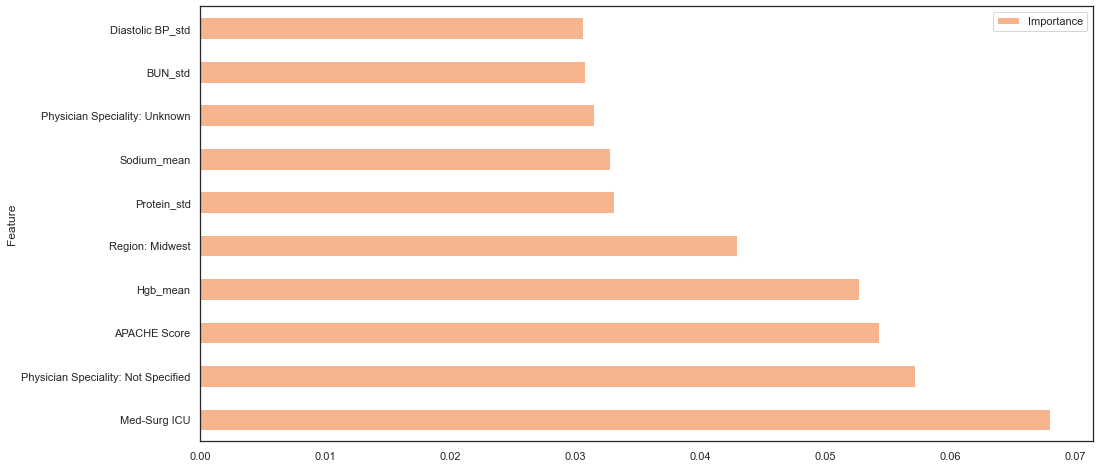

In [140]:
feature_importance.nlargest(10,'Importance').plot(kind='barh',stacked=False, figsize=(16,8), x='Feature')

# Without tuning or pretraining

In [141]:
TabNet = TabNetClassifier()

Device used : cpu


In [142]:
TabNet.fit(X_train_res, np.ravel(y_train))

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.11101 |  0:00:01s
epoch 1  | loss: 0.8255  |  0:00:02s
epoch 2  | loss: 0.72558 |  0:00:03s
epoch 3  | loss: 0.69485 |  0:00:04s
epoch 4  | loss: 0.67698 |  0:00:04s
epoch 5  | loss: 0.66004 |  0:00:05s
epoch 6  | loss: 0.65198 |  0:00:06s
epoch 7  | loss: 0.64598 |  0:00:06s
epoch 8  | loss: 0.64105 |  0:00:08s
epoch 9  | loss: 0.63376 |  0:00:09s
epoch 10 | loss: 0.62628 |  0:00:09s
epoch 11 | loss: 0.62271 |  0:00:10s
epoch 12 | loss: 0.62101 |  0:00:10s
epoch 13 | loss: 0.61583 |  0:00:11s
epoch 14 | loss: 0.61127 |  0:00:12s
epoch 15 | loss: 0.61265 |  0:00:13s
epoch 16 | loss: 0.60853 |  0:00:14s
epoch 17 | loss: 0.60043 |  0:00:15s
epoch 18 | loss: 0.59841 |  0:00:15s
epoch 19 | loss: 0.58681 |  0:00:16s
epoch 20 | loss: 0.58653 |  0:00:17s
epoch 21 | loss: 0.57715 |  0:00:17s
epoch 22 | loss: 0.57024 |  0:00:18s
epoch 23 | loss: 0.56347 |  0:00:19s
epoch 24 | loss: 0.55451 |  0:00:20s
ep

In [143]:
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, TabNet.predict(X_test_res)))
print('Average Precision is:', metrics.average_precision_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, TabNet.predict(X_test_res), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, TabNet.predict(X_test_res)))
print('#################################################')

Results:
AUROC is: 0.8289361001317522
Accuracy is: 0.7559055118110236
Average Precision is: 0.8421126992554118
Weighted F1 is: 0.7559314559153874
Sensitivity is: 0.7336956521739131
#################################################


In [ ]:
feature_importance = pd.DataFrame(list(zip(features, TabNet.feature_importances_)),
              columns=['Feature','Importance'])

<AxesSubplot:ylabel='Feature'>

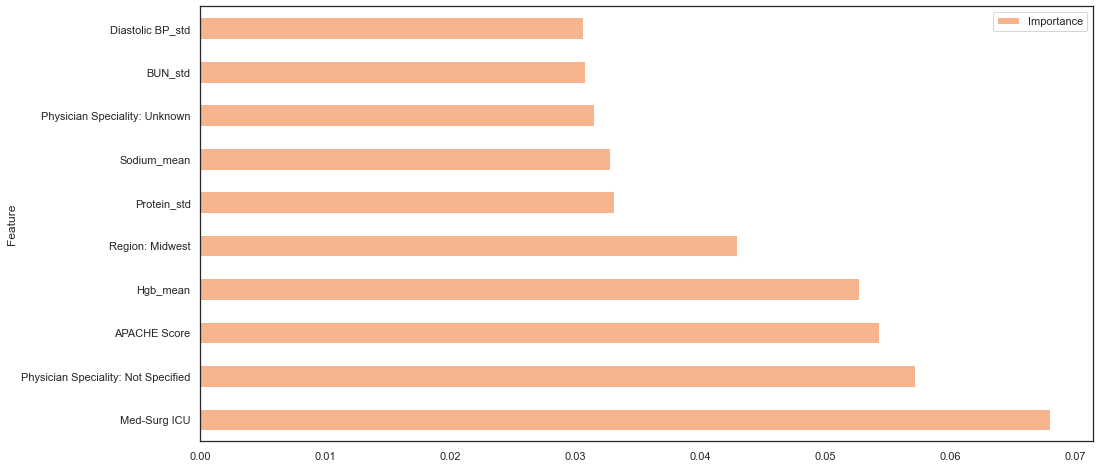

In [144]:
feature_importance.nlargest(10,'Importance').plot(kind='barh',stacked=False, figsize=(16,8), x='Feature')

# Pretraining

In [201]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer()

Device used : cpu


In [202]:
unsupervised_model.fit(X_train = X_train_res,
    max_epochs=1000, patience=5,
    pretraining_ratio=0.8)

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 76.94967|  0:00:00s
epoch 1  | loss: 121900.33341|  0:00:01s
epoch 2  | loss: 109072.99274|  0:00:02s
epoch 3  | loss: 80003.52995|  0:00:03s
epoch 4  | loss: 32527.30412|  0:00:03s
epoch 5  | loss: 24246.81216|  0:00:04s
epoch 6  | loss: 6650.75338|  0:00:05s
epoch 7  | loss: 12.94041|  0:00:05s
epoch 8  | loss: 11.39204|  0:00:06s
epoch 9  | loss: 9.29917 |  0:00:07s
epoch 10 | loss: 3096.70278|  0:00:07s
epoch 11 | loss: 6.80991 |  0:00:08s
epoch 12 | loss: 13835.40382|  0:00:08s
epoch 13 | loss: 3725.50113|  0:00:09s
epoch 14 | loss: 1099.34642|  0:00:09s
epoch 15 | loss: 34420.29553|  0:00:10s
epoch 16 | loss: 1487.94475|  0:00:10s
epoch 17 | loss: 3.37099 |  0:00:11s
epoch 18 | loss: 6574.19716|  0:00:11s
epoch 19 | loss: 2.62613 |  0:00:12s
epoch 20 | loss: 48275.03721|  0:00:12s
epoch 21 | loss: 2.42525 |  0:00:12s
epoch 22 | loss: 2.08901 |  0:00:13s
epoch 23 | loss: 2.03265 |  0:00:13s
e

epoch 212| loss: 3191.84511|  0:02:00s
epoch 213| loss: 1.33615 |  0:02:00s
epoch 214| loss: 35853.16663|  0:02:01s
epoch 215| loss: 7019.12249|  0:02:01s
epoch 216| loss: 1932.2666|  0:02:02s
epoch 217| loss: 1124.35677|  0:02:02s
epoch 218| loss: 6717.5441|  0:02:03s
epoch 219| loss: 37222.32796|  0:02:04s
epoch 220| loss: 96199.69534|  0:02:04s
epoch 221| loss: 20488.46456|  0:02:06s
epoch 222| loss: 18332.3354|  0:02:07s
epoch 223| loss: 13583.43028|  0:02:08s
epoch 224| loss: 1.23722 |  0:02:09s
epoch 225| loss: 7575.74281|  0:02:09s
epoch 226| loss: 348.03882|  0:02:10s
epoch 227| loss: 1.16658 |  0:02:10s
epoch 228| loss: 1988.04285|  0:02:11s
epoch 229| loss: 1894.35851|  0:02:12s
epoch 230| loss: 1.07132 |  0:02:12s
epoch 231| loss: 1392.42681|  0:02:12s
epoch 232| loss: 1.08761 |  0:02:13s
epoch 233| loss: 213.23175|  0:02:13s
epoch 234| loss: 484.62454|  0:02:14s
epoch 235| loss: 1.07547 |  0:02:15s
epoch 236| loss: 7631.58423|  0:02:15s
epoch 237| loss: 11808.71801|  0:02:1

epoch 428| loss: 3109.40801|  0:04:09s
epoch 429| loss: 383.39867|  0:04:10s
epoch 430| loss: 4228.40411|  0:04:10s
epoch 431| loss: 59.11314|  0:04:10s
epoch 432| loss: 71.11949|  0:04:11s
epoch 433| loss: 2238.43533|  0:04:11s
epoch 434| loss: 1.02622 |  0:04:12s
epoch 435| loss: 135.05313|  0:04:12s
epoch 436| loss: 1.00821 |  0:04:13s
epoch 437| loss: 1.01176 |  0:04:13s
epoch 438| loss: 0.99338 |  0:04:14s
epoch 439| loss: 11.35941|  0:04:14s
epoch 440| loss: 3832.07355|  0:04:15s
epoch 441| loss: 7080.83428|  0:04:15s
epoch 442| loss: 212.7957|  0:04:16s
epoch 443| loss: 1.09501 |  0:04:16s
epoch 444| loss: 1.01996 |  0:04:16s
epoch 445| loss: 1330.75627|  0:04:17s
epoch 446| loss: 1.00562 |  0:04:17s
epoch 447| loss: 1.00274 |  0:04:18s
epoch 448| loss: 0.99422 |  0:04:18s
epoch 449| loss: 0.99557 |  0:04:19s
epoch 450| loss: 179.21301|  0:04:19s
epoch 451| loss: 784.37892|  0:04:20s
epoch 452| loss: 1326.80322|  0:04:20s
epoch 453| loss: 408.14436|  0:04:21s
epoch 454| loss: 98

epoch 646| loss: 0.94664 |  0:06:05s
epoch 647| loss: 0.95867 |  0:06:06s
epoch 648| loss: 216.80185|  0:06:06s
epoch 649| loss: 0.96042 |  0:06:07s
epoch 650| loss: 0.96276 |  0:06:08s
epoch 651| loss: 254.66171|  0:06:08s
epoch 652| loss: 598.15357|  0:06:09s
epoch 653| loss: 0.96158 |  0:06:09s
epoch 654| loss: 0.95515 |  0:06:10s
epoch 655| loss: 37.74402|  0:06:10s
epoch 656| loss: 330.31625|  0:06:11s
epoch 657| loss: 82.7548 |  0:06:11s
epoch 658| loss: 1696.91636|  0:06:12s
epoch 659| loss: 7232.96856|  0:06:13s
epoch 660| loss: 4094.77774|  0:06:13s
epoch 661| loss: 0.95355 |  0:06:14s
epoch 662| loss: 0.96046 |  0:06:14s
epoch 663| loss: 176.37223|  0:06:15s
epoch 664| loss: 0.94339 |  0:06:15s
epoch 665| loss: 0.95037 |  0:06:16s
epoch 666| loss: 48.69459|  0:06:17s
epoch 667| loss: 0.94983 |  0:06:18s
epoch 668| loss: 0.93732 |  0:06:18s
epoch 669| loss: 373.14514|  0:06:19s
epoch 670| loss: 4764.07673|  0:06:20s
epoch 671| loss: 0.96276 |  0:06:20s
epoch 672| loss: 0.95671

epoch 864| loss: 0.95237 |  0:08:15s
epoch 865| loss: 137.11067|  0:08:16s
epoch 866| loss: 0.93433 |  0:08:16s
epoch 867| loss: 75.90832|  0:08:17s
epoch 868| loss: 29.66756|  0:08:17s
epoch 869| loss: 59.23837|  0:08:18s
epoch 870| loss: 4.29993 |  0:08:19s
epoch 871| loss: 20.58946|  0:08:19s
epoch 872| loss: 0.92993 |  0:08:20s
epoch 873| loss: 159.39147|  0:08:20s
epoch 874| loss: 0.93508 |  0:08:21s
epoch 875| loss: 0.92524 |  0:08:21s
epoch 876| loss: 128.7495|  0:08:22s
epoch 877| loss: 0.92318 |  0:08:22s
epoch 878| loss: 83.91579|  0:08:23s
epoch 879| loss: 0.92294 |  0:08:23s
epoch 880| loss: 0.93674 |  0:08:24s
epoch 881| loss: 0.93412 |  0:08:25s
epoch 882| loss: 0.92737 |  0:08:25s
epoch 883| loss: 0.92985 |  0:08:25s
epoch 884| loss: 0.93622 |  0:08:26s
epoch 885| loss: 0.92476 |  0:08:27s
epoch 886| loss: 0.91191 |  0:08:27s
epoch 887| loss: 464.95056|  0:08:28s
epoch 888| loss: 865.39206|  0:08:28s
epoch 889| loss: 1805.48559|  0:08:29s
epoch 890| loss: 34.38422|  0:08

In [203]:
TabNet = TabNetClassifier()

Device used : cpu


In [206]:
model = TabNet.fit(
    X_train=X_train_res, y_train=np.ravel(y_train),
    max_epochs=100,
    from_unsupervised=unsupervised_model) 

No early stopping will be performed, last training weights will be used.
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.85983 |  0:00:00s
epoch 1  | loss: 0.63057 |  0:00:01s
epoch 2  | loss: 0.60481 |  0:00:01s
epoch 3  | loss: 0.59042 |  0:00:02s
epoch 4  | loss: 0.58017 |  0:00:03s
epoch 5  | loss: 0.57    |  0:00:03s
epoch 6  | loss: 0.5619  |  0:00:04s
epoch 7  | loss: 0.54696 |  0:00:04s
epoch 8  | loss: 0.53828 |  0:00:05s
epoch 9  | loss: 0.5302  |  0:00:06s
epoch 10 | loss: 0.5207  |  0:00:06s
epoch 11 | loss: 0.50858 |  0:00:07s
epoch 12 | loss: 0.49311 |  0:00:08s
epoch 13 | loss: 0.48637 |  0:00:08s
epoch 14 | loss: 0.47567 |  0:00:09s
epoch 15 | loss: 0.4657  |  0:00:10s
epoch 16 | loss: 0.4519  |  0:00:10s
epoch 17 | loss: 0.4482  |  0:00:11s
epoch 18 | loss: 0.43725 |  0:00:12s
epoch 19 | loss: 0.42865 |  0:00:12s
epoch 20 | loss: 0.42602 |  0:00:13s
epoch 21 | loss: 0.41684 |  0:00:13s
epoch 22 | loss: 0.40849 |  0:00:14s
epoch 23 | loss: 0.41422 |  0:

In [205]:
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, TabNet.predict(X_test_res)))
print('Average Precision is:', metrics.average_precision_score(y_test, TabNet.predict_proba(X_test_res)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, TabNet.predict(X_test_res), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, TabNet.predict(X_test_res)))
print('#################################################')

Results:
AUROC is: 0.831436860241208
Accuracy is: 0.7609673790776152
Average Precision is: 0.8213803063895732
Weighted F1 is: 0.7606693980284627
Sensitivity is: 0.7141304347826087
#################################################


In [155]:
feature_importance = pd.DataFrame(list(zip(features, TabNet.feature_importances_)),
              columns=['Feature','Importance'])

<AxesSubplot:ylabel='Feature'>

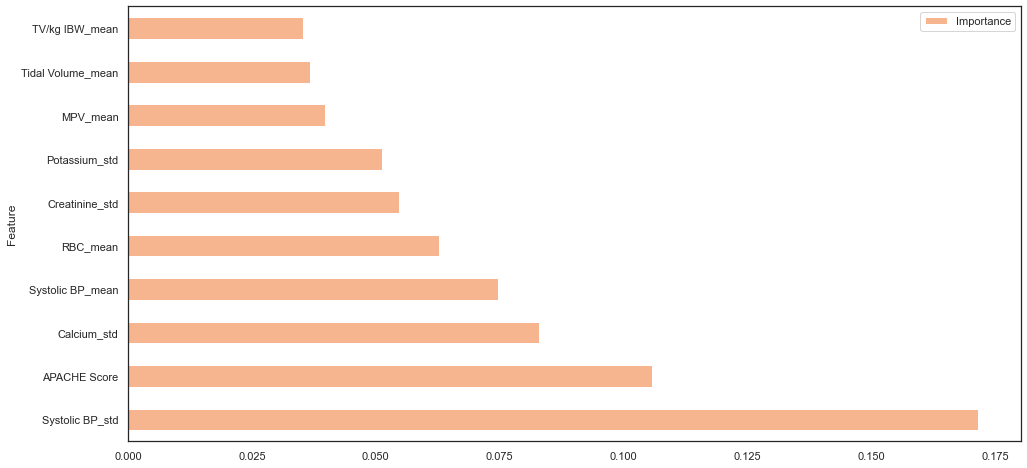

In [156]:
feature_importance.nlargest(10,'Importance').plot(kind='barh',stacked=False, figsize=(16,8), x='Feature')

In [211]:
# Define the imputation and tuning pipeline
TabNet = TabNetClassifier()
imputer = IterativeImputer()
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])

Device used : cpu


In [212]:
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, np.ravel(y_train), cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 5))

KeyboardInterrupt: 

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("AUC Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Learning curve

In [184]:
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, np.ravel(y_train), cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device use

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.9339  |  0:00:00s
epoch 1  | loss: 0.9063  |  0:00:00s
epoch 2  | loss: 0.83689 |  0:00:00s
epoch 3  | loss: 0.79721 |  0:00:00s
epoch 4  | loss: 0.83549 |  0:00:00s
epoch 5  | loss: 0.79531 |  0:00:00s
epoch 6  | loss: 0.75207 |  0:00:00s
epoch 7  | loss: 0.73739 |  0:00:00s
epoch 8  | loss: 0.75369 |  0:00:00s
epoch 9  | loss: 0.70732 |  0:00:01s
epoch 10 | loss: 0.69312 |  0:00:01s
epoch 11 | loss: 0.68562 |  0:00:01s
epoch 12 | loss: 0.69766 |  0:00:01s
epoch 13 | loss: 0.68885 |  0:00:01s
epoch 14 | loss: 0.67918 |  0:00:01s
epoch 15 | loss: 0.67951 |  0:00:01s
epoch 16 | loss: 0.6725  |  0:00:01s
epoch 17 | loss: 0.66386 |  0:00:01s
epoch 18 | loss: 0.66687 |  0:00:01s
epoch 19 | loss: 0.66854 |  0:00:01s
epoch 20 | loss: 0.66086 |  0:00:01s
epoch 21 | loss: 0.65556 |  0:00:01s
epoch 22 | loss: 0.65253 |  0:00:02s
epoch 23 | loss: 0.67201 |  0:00:02s
epoch 24 | loss: 0.65866 |  0:00:02s
ep

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.74858 |  0:00:00s
epoch 1  | loss: 0.79187 |  0:00:00s
epoch 2  | loss: 0.74765 |  0:00:00s
epoch 3  | loss: 0.6217  |  0:00:00s
epoch 4  | loss: 0.71902 |  0:00:00s
epoch 5  | loss: 0.55268 |  0:00:01s
epoch 6  | loss: 0.66907 |  0:00:01s
epoch 7  | loss: 0.56601 |  0:00:01s
epoch 8  | loss: 0.55463 |  0:00:01s
epoch 9  | loss: 0.52802 |  0:00:01s
epoch 10 | loss: 0.48835 |  0:00:01s
epoch 11 | loss: 0.4531  |  0:00:01s
epoch 12 | loss: 0.40308 |  0:00:01s
epoch 13 | loss: 0.36794 |  0:00:01s
epoch 14 | loss: 0.31619 |  0:00:01s
epoch 15 | loss: 0.31341 |  0:00:01s
epoch 16 | loss: 0.28956 |  0:00:01s
epoch 17 | loss: 0.27583 |  0:00:01s
epoch 18 | loss: 0.237   |  0:00:01s
epoch 19 | loss: 0.20181 |  0:00:01s
epoch 20 | loss: 0.17035 |  0:00:01s
epoch 21 | loss: 0.16858 |  0:00:01s
epoch 22 | loss: 0.11213 |  0:00:01s
epoch 23 | loss: 0.06835 |  0:00:01s
epoch 24 | loss: 0.05411 |  0:00:01s
ep

epoch 64 | loss: 0.56102 |  0:00:15s
epoch 65 | loss: 0.55156 |  0:00:16s
epoch 66 | loss: 0.53918 |  0:00:16s
epoch 67 | loss: 0.54243 |  0:00:16s
epoch 68 | loss: 0.5538  |  0:00:16s
epoch 69 | loss: 0.55774 |  0:00:17s
epoch 70 | loss: 0.53916 |  0:00:17s
epoch 71 | loss: 0.5362  |  0:00:17s
epoch 72 | loss: 0.52974 |  0:00:17s
epoch 73 | loss: 0.5202  |  0:00:17s
epoch 74 | loss: 0.52432 |  0:00:18s
epoch 75 | loss: 0.53517 |  0:00:18s
epoch 76 | loss: 0.53478 |  0:00:18s
epoch 77 | loss: 0.52586 |  0:00:18s
epoch 78 | loss: 0.52486 |  0:00:18s
epoch 79 | loss: 0.52356 |  0:00:19s
epoch 80 | loss: 0.52584 |  0:00:19s
epoch 81 | loss: 0.53144 |  0:00:19s
epoch 82 | loss: 0.51298 |  0:00:19s
epoch 83 | loss: 0.49768 |  0:00:20s
epoch 84 | loss: 0.51231 |  0:00:20s
epoch 85 | loss: 0.49144 |  0:00:20s
epoch 86 | loss: 0.49068 |  0:00:20s
epoch 87 | loss: 0.49759 |  0:00:20s
epoch 88 | loss: 0.51471 |  0:00:21s
epoch 89 | loss: 0.52388 |  0:00:21s
epoch 90 | loss: 0.50104 |  0:00:21s
e

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.23076 |  0:00:00s
epoch 1  | loss: 1.06193 |  0:00:00s
epoch 2  | loss: 0.95893 |  0:00:00s
epoch 3  | loss: 0.94807 |  0:00:00s
epoch 4  | loss: 0.89381 |  0:00:01s
epoch 5  | loss: 0.88052 |  0:00:01s
epoch 6  | loss: 0.78758 |  0:00:01s
epoch 7  | loss: 0.79904 |  0:00:01s
epoch 8  | loss: 0.79342 |  0:00:01s
epoch 9  | loss: 0.77249 |  0:00:01s
epoch 10 | loss: 0.7544  |  0:00:01s
epoch 11 | loss: 0.7183  |  0:00:01s
epoch 12 | loss: 0.71457 |  0:00:01s
epoch 13 | loss: 0.70832 |  0:00:01s
epoch 14 | loss: 0.70796 |  0:00:02s
epoch 15 | loss: 0.70876 |  0:00:02s
epoch 16 | loss: 0.69091 |  0:00:02s
epoch 17 | loss: 0.6798  |  0:00:02s
epoch 18 | loss: 0.69181 |  0:00:02s
epoch 19 | loss: 0.68447 |  0:00:02s
epoch 20 | loss: 0.68217 |  0:00:02s
epoch 21 | loss: 0.67864 |  0:00:02s
epoch 22 | loss: 0.6879  |  0:00:03s
epoch 23 | loss: 0.69119 |  0:00:03s
epoch 24 | loss: 0.67946 |  0:00:03s
ep

epoch 8  | loss: 0.66778 |  0:00:05s
epoch 9  | loss: 0.66544 |  0:00:05s
epoch 10 | loss: 0.66222 |  0:00:06s
epoch 11 | loss: 0.65585 |  0:00:06s
epoch 12 | loss: 0.65884 |  0:00:07s
epoch 13 | loss: 0.65778 |  0:00:07s
epoch 14 | loss: 0.65298 |  0:00:08s
epoch 15 | loss: 0.64646 |  0:00:09s
epoch 16 | loss: 0.64893 |  0:00:09s
epoch 17 | loss: 0.64185 |  0:00:10s
epoch 18 | loss: 0.63744 |  0:00:10s
epoch 19 | loss: 0.63    |  0:00:11s
epoch 20 | loss: 0.62415 |  0:00:11s
epoch 21 | loss: 0.622   |  0:00:12s
epoch 22 | loss: 0.61774 |  0:00:12s
epoch 23 | loss: 0.61551 |  0:00:13s
epoch 24 | loss: 0.61143 |  0:00:13s
epoch 25 | loss: 0.60722 |  0:00:14s
epoch 26 | loss: 0.60613 |  0:00:14s
epoch 27 | loss: 0.60874 |  0:00:15s
epoch 28 | loss: 0.59781 |  0:00:15s
epoch 29 | loss: 0.59608 |  0:00:16s
epoch 30 | loss: 0.593   |  0:00:16s
epoch 31 | loss: 0.59466 |  0:00:17s
epoch 32 | loss: 0.59019 |  0:00:17s
epoch 33 | loss: 0.58873 |  0:00:18s
epoch 34 | loss: 0.57913 |  0:00:18s
e

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.96581 |  0:00:00s
epoch 1  | loss: 0.88678 |  0:00:00s
epoch 2  | loss: 0.90091 |  0:00:00s
epoch 3  | loss: 0.84606 |  0:00:00s
epoch 4  | loss: 0.79551 |  0:00:00s
epoch 5  | loss: 0.80405 |  0:00:00s
epoch 6  | loss: 0.75909 |  0:00:00s
epoch 7  | loss: 0.74433 |  0:00:00s
epoch 8  | loss: 0.77812 |  0:00:00s
epoch 9  | loss: 0.72788 |  0:00:00s
epoch 10 | loss: 0.72724 |  0:00:00s
epoch 11 | loss: 0.73225 |  0:00:00s
epoch 12 | loss: 0.71773 |  0:00:00s
epoch 13 | loss: 0.71275 |  0:00:00s
epoch 14 | loss: 0.70576 |  0:00:00s
epoch 15 | loss: 0.70528 |  0:00:00s
epoch 16 | loss: 0.6946  |  0:00:00s
epoch 17 | loss: 0.704   |  0:00:01s
epoch 18 | loss: 0.69447 |  0:00:01s
epoch 19 | loss: 0.70065 |  0:00:01s
epoch 20 | loss: 0.66752 |  0:00:01s
epoch 21 | loss: 0.6754  |  0:00:01s
epoch 22 | loss: 0.67851 |  0:00:01s
epoch 23 | loss: 0.67608 |  0:00:01s
epoch 24 | loss: 0.67566 |  0:00:01s
ep

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.91677 |  0:00:00s
epoch 1  | loss: 0.81896 |  0:00:00s
epoch 2  | loss: 0.81285 |  0:00:00s
epoch 3  | loss: 0.7996  |  0:00:00s
epoch 4  | loss: 0.75522 |  0:00:00s
epoch 5  | loss: 0.73777 |  0:00:01s
epoch 6  | loss: 0.71546 |  0:00:01s
epoch 7  | loss: 0.72128 |  0:00:01s
epoch 8  | loss: 0.71824 |  0:00:01s
epoch 9  | loss: 0.70304 |  0:00:01s
epoch 10 | loss: 0.69667 |  0:00:01s
epoch 11 | loss: 0.7112  |  0:00:01s
epoch 12 | loss: 0.69493 |  0:00:01s
epoch 13 | loss: 0.6882  |  0:00:01s
epoch 14 | loss: 0.6989  |  0:00:01s
epoch 15 | loss: 0.68539 |  0:00:02s
epoch 16 | loss: 0.68979 |  0:00:02s
epoch 17 | loss: 0.67912 |  0:00:02s
epoch 18 | loss: 0.67777 |  0:00:02s
epoch 19 | loss: 0.68793 |  0:00:02s
epoch 20 | loss: 0.68147 |  0:00:02s
epoch 21 | loss: 0.67202 |  0:00:02s
epoch 22 | loss: 0.67557 |  0:00:02s
epoch 23 | loss: 0.67187 |  0:00:02s
epoch 24 | loss: 0.67049 |  0:00:02s
ep

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.09587 |  0:00:00s
epoch 1  | loss: 0.87074 |  0:00:00s
epoch 2  | loss: 0.88051 |  0:00:00s
epoch 3  | loss: 0.74922 |  0:00:00s
epoch 4  | loss: 0.74921 |  0:00:00s
epoch 5  | loss: 0.69729 |  0:00:00s
epoch 6  | loss: 0.72775 |  0:00:00s
epoch 7  | loss: 0.69038 |  0:00:00s
epoch 8  | loss: 0.71004 |  0:00:00s
epoch 9  | loss: 0.6982  |  0:00:00s
epoch 10 | loss: 0.72919 |  0:00:00s
epoch 11 | loss: 0.70027 |  0:00:00s
epoch 12 | loss: 0.73209 |  0:00:00s
epoch 13 | loss: 0.69685 |  0:00:00s
epoch 14 | loss: 0.68984 |  0:00:00s
epoch 15 | loss: 0.69632 |  0:00:00s
epoch 16 | loss: 0.68972 |  0:00:00s
epoch 17 | loss: 0.68297 |  0:00:00s
epoch 18 | loss: 0.661   |  0:00:00s
epoch 19 | loss: 0.66473 |  0:00:00s
epoch 20 | loss: 0.65608 |  0:00:00s
epoch 21 | loss: 0.6718  |  0:00:00s
epoch 22 | loss: 0.6805  |  0:00:01s
epoch 23 | loss: 0.66353 |  0:00:01s
epoch 24 | loss: 0.68212 |  0:00:01s
ep

epoch 96 | loss: 0.42132 |  0:01:05s
epoch 97 | loss: 0.42284 |  0:01:06s
epoch 98 | loss: 0.41862 |  0:01:06s
epoch 99 | loss: 0.40862 |  0:01:07s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.7868  |  0:00:01s
epoch 1  | loss: 0.70832 |  0:00:01s
epoch 2  | loss: 0.70004 |  0:00:02s
epoch 3  | loss: 0.69307 |  0:00:03s
epoch 4  | loss: 0.68495 |  0:00:04s
epoch 5  | loss: 0.67933 |  0:00:04s
epoch 6  | loss: 0.6615  |  0:00:05s
epoch 7  | loss: 0.65951 |  0:00:06s
epoch 8  | loss: 0.64896 |  0:00:06s
epoch 9  | loss: 0.64416 |  0:00:07s
epoch 10 | loss: 0.64447 |  0:00:08s
epoch 11 | loss: 0.64301 |  0:00:09s
epoch 12 | loss: 0.64177 |  0:00:09s
epoch 13 | loss: 0.63998 |  0:00:10s
epoch 14 | loss: 0.63739 |  0:00:11s
epoch 15 | loss: 0.63415 |  0:00:11s
epoch 16 | loss: 0.62847 |  0:00:12s
epoch 17 | loss: 0.62621 |  0:00:13s
epoch 18 | loss: 0.6272  |  0:00:14s
epoch 19 | loss: 0.61802 |  0:00:14s
epoch 20 | loss: 0.62142 |  0:00:15s
ep

epoch 8  | loss: 0.70553 |  0:00:02s
epoch 9  | loss: 0.69099 |  0:00:02s
epoch 10 | loss: 0.6989  |  0:00:02s
epoch 11 | loss: 0.69542 |  0:00:03s
epoch 12 | loss: 0.68492 |  0:00:03s
epoch 13 | loss: 0.68254 |  0:00:03s
epoch 14 | loss: 0.6745  |  0:00:03s
epoch 15 | loss: 0.68125 |  0:00:04s
epoch 16 | loss: 0.67815 |  0:00:04s
epoch 17 | loss: 0.68471 |  0:00:04s
epoch 18 | loss: 0.68356 |  0:00:04s
epoch 19 | loss: 0.67347 |  0:00:04s
epoch 20 | loss: 0.6723  |  0:00:05s
epoch 21 | loss: 0.66943 |  0:00:05s
epoch 22 | loss: 0.6645  |  0:00:05s
epoch 23 | loss: 0.66059 |  0:00:05s
epoch 24 | loss: 0.6621  |  0:00:06s
epoch 25 | loss: 0.65957 |  0:00:06s
epoch 26 | loss: 0.65887 |  0:00:06s
epoch 27 | loss: 0.66145 |  0:00:06s
epoch 28 | loss: 0.6599  |  0:00:06s
epoch 29 | loss: 0.64942 |  0:00:07s
epoch 30 | loss: 0.63953 |  0:00:07s
epoch 31 | loss: 0.65131 |  0:00:07s
epoch 32 | loss: 0.64312 |  0:00:07s
epoch 33 | loss: 0.63848 |  0:00:08s
epoch 34 | loss: 0.63016 |  0:00:08s
e

epoch 32 | loss: 0.59374 |  0:00:15s
epoch 33 | loss: 0.58674 |  0:00:16s
epoch 34 | loss: 0.584   |  0:00:16s
epoch 35 | loss: 0.58122 |  0:00:17s
epoch 36 | loss: 0.57302 |  0:00:17s
epoch 37 | loss: 0.58028 |  0:00:18s
epoch 38 | loss: 0.5768  |  0:00:18s
epoch 39 | loss: 0.57547 |  0:00:19s
epoch 40 | loss: 0.57343 |  0:00:19s
epoch 41 | loss: 0.57101 |  0:00:19s
epoch 42 | loss: 0.5638  |  0:00:20s
epoch 43 | loss: 0.56793 |  0:00:20s
epoch 44 | loss: 0.563   |  0:00:21s
epoch 45 | loss: 0.55988 |  0:00:21s
epoch 46 | loss: 0.56008 |  0:00:22s
epoch 47 | loss: 0.55873 |  0:00:22s
epoch 48 | loss: 0.55231 |  0:00:23s
epoch 49 | loss: 0.55554 |  0:00:23s
epoch 50 | loss: 0.54856 |  0:00:24s
epoch 51 | loss: 0.54617 |  0:00:24s
epoch 52 | loss: 0.54268 |  0:00:25s
epoch 53 | loss: 0.5399  |  0:00:25s
epoch 54 | loss: 0.53269 |  0:00:25s
epoch 55 | loss: 0.53837 |  0:00:26s
epoch 56 | loss: 0.53811 |  0:00:26s
epoch 57 | loss: 0.53595 |  0:00:27s
epoch 58 | loss: 0.53177 |  0:00:27s
e

epoch 90 | loss: 0.46072 |  0:00:11s
epoch 91 | loss: 0.47181 |  0:00:12s
epoch 92 | loss: 0.47462 |  0:00:12s
epoch 93 | loss: 0.45226 |  0:00:12s
epoch 94 | loss: 0.46595 |  0:00:12s
epoch 95 | loss: 0.45201 |  0:00:12s
epoch 96 | loss: 0.46019 |  0:00:12s
epoch 97 | loss: 0.44048 |  0:00:12s
epoch 98 | loss: 0.44068 |  0:00:12s
epoch 99 | loss: 0.44068 |  0:00:13s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.88935 |  0:00:00s
epoch 1  | loss: 0.81035 |  0:00:00s
epoch 2  | loss: 0.77738 |  0:00:00s
epoch 3  | loss: 0.73781 |  0:00:01s
epoch 4  | loss: 0.7237  |  0:00:01s
epoch 5  | loss: 0.71736 |  0:00:01s
epoch 6  | loss: 0.69678 |  0:00:01s
epoch 7  | loss: 0.69649 |  0:00:01s
epoch 8  | loss: 0.68989 |  0:00:02s
epoch 9  | loss: 0.68968 |  0:00:02s
epoch 10 | loss: 0.68346 |  0:00:02s
epoch 11 | loss: 0.68921 |  0:00:02s
epoch 12 | loss: 0.68363 |  0:00:02s
epoch 13 | loss: 0.67604 |  0:00:03s
epoch 14 | loss: 0.67812 |  0:00:03s
ep

In [185]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [186]:
test_mean

array([0.53442669, 0.52109312, 0.56318339, 0.57144199, 0.55848838,
       0.56201407, 0.55875553, 0.60246224, 0.59630545, 0.71241383,
       0.6758981 , 0.7034726 , 0.66877016, 0.70518457, 0.66505242,
       0.66447802, 0.68362787, 0.65830272, 0.72146437, 0.73619206,
       0.74180379, 0.7230111 , 0.73162454, 0.74404634, 0.75081004,
       0.74196372, 0.7463732 , 0.76430997, 0.74844852, 0.77425087,
       0.76076131, 0.7718508 , 0.77489095, 0.76996004, 0.77928292,
       0.78392405, 0.77544668, 0.77386763, 0.78928408, 0.78728431,
       0.77907015, 0.80422671, 0.78517706, 0.80030544, 0.80628744,
       0.81144082, 0.80660529, 0.80712573, 0.80447854, 0.81871429])

In [213]:
test_std

array([0.02820038, 0.01961045, 0.04654258, 0.04249866, 0.029818  ,
       0.05049058, 0.06215357, 0.03036662, 0.03692544, 0.06955233,
       0.03145029, 0.01904763, 0.01407571, 0.02754642, 0.04578069,
       0.04305917, 0.01627528, 0.03528033, 0.01093899, 0.01928803,
       0.021358  , 0.03006057, 0.01894129, 0.03436432, 0.01822438,
       0.00977223, 0.01844941, 0.00617196, 0.01994388, 0.01611045,
       0.01716126, 0.01660705, 0.03280132, 0.01374331, 0.02557968,
       0.01750046, 0.02899394, 0.00579425, 0.02640718, 0.00897659,
       0.01883677, 0.01635519, 0.02136922, 0.00960243, 0.01604883,
       0.0182166 , 0.02307106, 0.01211866, 0.01366599, 0.02523054])

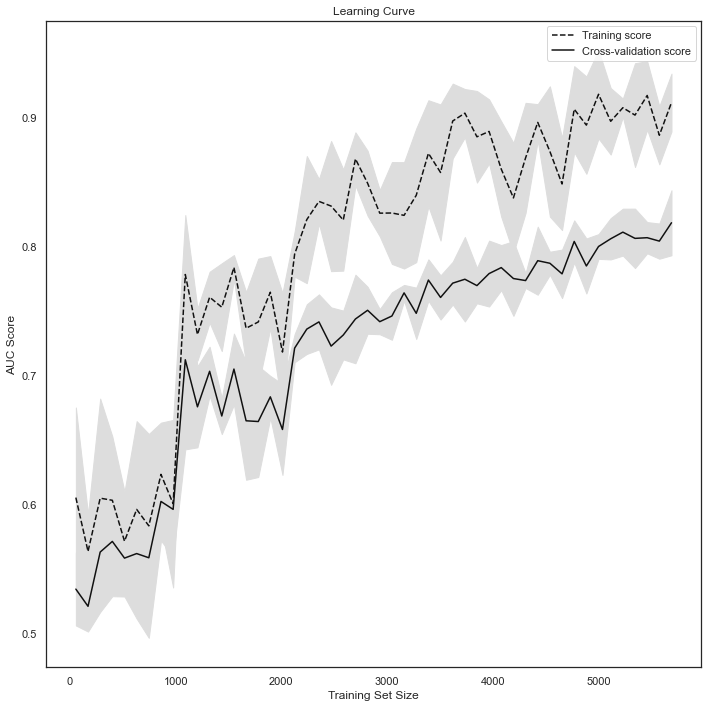

In [188]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("AUC Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()